 # Aspects 
 time distribution of crime, victim data, crime type, location, (optional)suspect(bias of police arrest),
 <br>
- Median Absolute Deviation: https://scipy.github.io/devdocs/generated/scipy.stats.median_absolute_deviation.html
 <br>
- Isolation Forest: <br>https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html<br>
                   https://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html
<br>
- DBScan: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

# goals breakdown
- run the default algorithm and see what's the result
- play with parameters
- visualize
- solve potential problems by tweaking the algorithms

Select crime reports that meet a criteria.
Generate coordinates to plot where:
X = Month since Jan 2010 *or some other start month
Y =  Number of reports with the matching criteria that occurred in that month

Then computer line of best fit for that data using Least Squares.
Compute goodness of fit with R2
After that run outlier detection of the data using the different methods we described
after detecting outliers for each method, graph the data and remove all the outliers the method detected
For each of these graphs generate and display a graph with new line of best fit for that data using Least Squares and also compute a goodness of fit with R2>
After that we can compare the new R2 values with the original R2 value before removing outliers to determine which method is performing best to best fit a line to the data.
As the result of our project we could determine the best ways to remove outliers in crime reports with the goal of showing trends in crimes




In [1]:
!pip install nltk==3.5
! pip install xgboost

import pandas as pd
import numpy as np
import collections
import re, string
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import IsolationForest


     |████████████████████████████████| 1.4 MB 19.0 MB/s 
     |████████████████████████████████| 82 kB 40.2 MB/s 
     |████████████████████████████████| 719 kB 65.4 MB/s 
     |████████████████████████████████| 69 kB 69.6 MB/s 
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434677 sha256=1234284e73f650e18efc1bb73e8793713fdd625c533bc05420af427a4b2ae0a1
  Stored in directory: /tmp/pip-ephem-wheel-cache-4d8f_alh/wheels/45/6c/46/a1865e7ba706b3817f5d1b2ff7ce8996aabdd0d03d47ba0266
Successfully built nltk
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 157.5 MB 95.4 MB/s 
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora

BORO_NM, CMPLNT_FR_DT, LAW_CAT_CD, LOC_OF_OCCUR_DESC, OFNS_DESC, PREM_TYP_DESC, SUSP_AGE_GROUP, SUSP_RACE, SUSP_SEX, VIC_AGE_GROUP, VIC_RACE, VIC_SEX, Latitude, Longitude

In [2]:
#build the train and test dataset.
from datetime import datetime

attr_list = ['BORO_NM', 'CMPLNT_FR_DT', 'LAW_CAT_CD', 'LOC_OF_OCCUR_DESC', 'OFNS_DESC', 'PREM_TYP_DESC', 'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX']

def make_dtypes(a_list):
    return {a:"category" if a != "CMPLNT_FR_DT" else str for a in a_list}

dateparse = lambda x: datetime.strptime(x, "%m/%d/%Y") if type(x) == str else np.nan
raw = pd.read_csv('/datasets/nypd_complaint_data_historic/NYPD_Complaint_Data_Historic.csv',
                     parse_dates=['CMPLNT_FR_DT'],
                    date_parser=dateparse, 
                    usecols = attr_list,
                    )
raw_current = pd.read_csv('/work/CS5112-Eval-Methods-for-Outlier-Detection/NYPD_Complaint_Data_Current__Year_To_Date_.csv',
                    parse_dates=['CMPLNT_FR_DT'],
                    date_parser=dateparse, 
                    usecols = attr_list,
                    )

raw = raw.append(raw_current, ignore_index=True)
raw = raw.astype(make_dtypes(attr_list))

#raw = raw.astype("Sparse[str]")

raw['CMPLNT_FR_DT'] = pd.to_datetime(raw['CMPLNT_FR_DT'], errors = 'coerce')
#raw = raw.sort_values(by=['CMPLNT_FR_DT'], ignore_index=True)
raw = raw[raw['CMPLNT_FR_DT'].notna()]
raw = raw[raw['OFNS_DESC'].notna()] # Only 4 are missing it, remove them
print("raw data: ", raw.shape)
raw


raw data:  (7270220, 12)


CMPLNT_FR_DT                       OFNS_DESC   LAW_CAT_CD  \
0         2015-05-28                   HARRASSMENT 2    VIOLATION   
1         2013-10-28  CRIMINAL MISCHIEF & RELATED OF  MISDEMEANOR   
2         2012-05-09               DANGEROUS WEAPONS  MISDEMEANOR   
3         2014-01-03                   GRAND LARCENY       FELONY   
4         2016-04-13  CRIMINAL MISCHIEF & RELATED OF  MISDEMEANOR   
...              ...                             ...          ...   
7289858   2020-01-01    ASSAULT 3 & RELATED OFFENSES  MISDEMEANOR   
7289859   2020-01-01    ASSAULT 3 & RELATED OFFENSES  MISDEMEANOR   
7289860   2020-01-01    ASSAULT 3 & RELATED OFFENSES  MISDEMEANOR   
7289861   2020-01-01                  FELONY ASSAULT       FELONY   
7289862   2020-01-01               DANGEROUS WEAPONS  MISDEMEANOR   

               BORO_NM LOC_OF_OCCUR_DESC               PREM_TYP_DESC  \
0                BRONX            INSIDE      RESIDENCE - APT. HOUSE   
1        STATEN ISLAND            INSIDE      RESIDENCE - APT. HOUSE   
2            MANHATTAN               NaN                      STREET   
3               QUEENS            INSIDE      RESIDENCE - APT. HOUSE   
4                BRONX               NaN             HIGHWAY/PARKWAY   
...                ...               ...                         ...   
7289858       BROOKLYN          FRONT OF                      STREET   
7289859         QUEENS            INSIDE  RESIDENCE - PUBLIC HOUSING   
7289860         QUEENS          FRONT OF                      STREET   
7289861          BRONX            INSIDE  RESIDENCE - PUBLIC HOUSING   
7289862         QUEENS               NaN            AIRPORT TERMINAL   

        SUSP_AGE_GROUP       SUSP_RACE SUSP_SEX VIC_AGE_GROUP  \
0                25-44           BLACK        M         25-44   
1                  NaN             NaN      NaN         45-64   
2                  NaN             NaN      NaN           NaN   
3                  NaN         UNKNOWN        M         45-64   
4                  NaN             NaN      NaN       UNKNOWN   
...                ...             ...      ...           ...   
7289858        UNKNOWN         UNKNOWN        U         25-44   
7289859          25-44           BLACK        F         25-44   
7289860        UNKNOWN         UNKNOWN        U         18-24   
7289861          45-64           BLACK        F         25-44   
7289862          25-44  BLACK HISPANIC        M       UNKNOWN   

                         VIC_RACE VIC_SEX  
0                  WHITE HISPANIC       F  
1                           WHITE       M  
2                         UNKNOWN       E  
3        ASIAN / PACIFIC ISLANDER       M  
4                         UNKNOWN       E  
...                           ...     ...  
7289858                   UNKNOWN       M  
7289859                     BLACK       F  
7289860            WHITE HISPANIC       F  
7289861                     BLACK       M  
7289862                   UNKNOWN       E  

[7270220 rows x 12 columns]

In [3]:
data=raw[attr_list]

print(data.shape)
#data = data.dropna(how='any') 
print(data.shape)

import datetime
from dateutil import rrule

#start_date = pd.Timestamp(2010, 2, 1)

#number of reports before start_date
#len(data[data.CMPLNT_FR_DT < start_date]) 


(7270220, 12)
(7270220, 12)


In [4]:
#data = data.fillna('0')
data.isnull().sum()

BORO_NM                11229
CMPLNT_FR_DT               0
LAW_CAT_CD                 0
LOC_OF_OCCUR_DESC    1522499
OFNS_DESC                  0
PREM_TYP_DESC          40362
SUSP_AGE_GROUP       4762625
SUSP_RACE            3398118
SUSP_SEX             3531107
VIC_AGE_GROUP        1626228
VIC_RACE                 304
VIC_SEX                  303
dtype: int64

In [5]:
data.iloc[20]

BORO_NM                                   BROOKLYN
CMPLNT_FR_DT                   2017-08-06 00:00:00
LAW_CAT_CD                             MISDEMEANOR
LOC_OF_OCCUR_DESC                           INSIDE
OFNS_DESC            OFF. AGNST PUB ORD SENSBLTY &
PREM_TYP_DESC                     RESTAURANT/DINER
SUSP_AGE_GROUP                             UNKNOWN
SUSP_RACE                                  UNKNOWN
SUSP_SEX                                         M
VIC_AGE_GROUP                                45-64
VIC_RACE                  ASIAN / PACIFIC ISLANDER
VIC_SEX                                          F
Name: 20, dtype: object

In [6]:
# attr_to_attr_mapping = {}
# for c_name in attr_list:
#     if c_name != "CMPLNT_FR_DT":
#         unique = data[c_name].unique()
#         mapping = dict(zip(unique, range(len(unique))))
#         attr_to_attr_mapping[c_name] = mapping
#         data = data.replace({c_name: mapping})
# #raw.sort_values(by=['CMPLNT_FR_DT'])["CMPLNT_FR_DT"][0:560]
# attr_to_attr_mapping
print (data.OFNS_DESC.cat.categories)


Index(['ABORTION', 'ADMINISTRATIVE CODE', 'ADMINISTRATIVE CODES',
       'AGRICULTURE & MRKTS LAW-UNCLASSIFIED',
       'ALCOHOLIC BEVERAGE CONTROL LAW', 'ANTICIPATORY OFFENSES', 'ARSON',
       'ASSAULT 3 & RELATED OFFENSES', 'BURGLAR'S TOOLS', 'BURGLARY',
       'CHILD ABANDONMENT/NON SUPPORT', 'CRIMINAL MISCHIEF & RELATED OF',
       'CRIMINAL TRESPASS', 'DANGEROUS DRUGS', 'DANGEROUS WEAPONS',
       'DISORDERLY CONDUCT', 'DISRUPTION OF A RELIGIOUS SERV',
       'ENDAN WELFARE INCOMP', 'ESCAPE 3', 'FELONY ASSAULT',
       'FELONY SEX CRIMES', 'FORGERY', 'FORTUNE TELLING', 'FRAUDS',
       'FRAUDULENT ACCOSTING', 'GAMBLING', 'GRAND LARCENY',
       'GRAND LARCENY OF MOTOR VEHICLE', 'HARRASSMENT 2',
       'HOMICIDE-NEGLIGENT,UNCLASSIFIE', 'HOMICIDE-NEGLIGENT-VEHICLE',
       'INTOXICATED & IMPAIRED DRIVING', 'INTOXICATED/IMPAIRED DRIVING',
       'JOSTLING', 'KIDNAPPING', 'KIDNAPPING & RELATED OFFENSES',
       'KIDNAPPING AND RELATED OFFENSES', 'LOITERING',
       'LOITERING FOR DRU

In [7]:
# https://stackoverflow.com/questions/19189362/getting-the-r-squared-value-using-curve-fit
def get_r2(x,y,popt,f):
    residuals = y - f(x, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)

#    correlation_matrix = np.corrcoef(x, y)
#    correlation_xy = correlation_matrix[0,1]
#    r_squared = correlation_xy**2
    return r_squared

In [8]:
from scipy import stats

def get_mad_z_scores(data):
    d = np.abs(data - np.median(data))
    mad = np.median(d)
    mzs = (0.6745*d)/mad if mad else 0.
    return mzs
# https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm
# check with modified Z-scores 
def is_mad_outlier(mad_z_scores, index, m=3.):
    return mad_z_scores[index]>m

def get_mad_outliers(mad_z_scores, m=3.):
    outliers = map(lambda z: -1 if z > m else 1, mad_z_scores) 
    return list(outliers)


In [9]:
#https://machinelearningmastery.com/curve-fitting-with-python/

def objective_1st(x, a, b, c):
    return a * x + b

def objective_2nd(x, a, b, c):
	return a * x + b * x**2 + c

def objective_3rd(x, a, b, c, d):
	return (a * x) + (b * x**2) + (c * x**3) + d

def objective_4th(x, a, b, c, d, e):
	return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + e

def objective_5th(x, a, b, c, d, e, f):
	return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + f

def objective_sin_1st(x, a, b): 
    return a * np.sin(b * x) 

def objective_sin_2nd(x, a, b, c, d):
	return a * npsin(b - x) + c * x**2 + d
 

In [10]:
import datetime
from dateutil import rrule

start_date = datetime.datetime(2006, 1, 1)
end_date = datetime.datetime(2020, 10, 5)
data[data.CMPLNT_FR_DT > start_date]

type_to_weekly_counts= {}

type_to_weekly_counts['All Types'] = pd.DataFrame({'week': [], 'count': [], 'outlier_type': [], 'week_dt': []})


w = 0
year = 0
for dt in rrule.rrule(rrule.WEEKLY, dtstart=start_date, until=end_date):
    w = w + 1
    if (year != dt.year):
        year = dt.year
        print(year)
        data_y = data[(data.CMPLNT_FR_DT.dt.year == dt.year)]

    data_yw = data_y[(data_y.CMPLNT_FR_DT.dt.week == dt.isocalendar()[1])]
    week_dt = data_yw['CMPLNT_FR_DT'].min()
    count = len(data_yw)

    type_to_weekly_counts['All Types'] = type_to_weekly_counts['All Types'].append({
                            'week': w, 'count': count, 'outlier_type': 0, 'week_dt': week_dt}, ignore_index=True)            

    for cat in data_yw.OFNS_DESC.cat.categories:
        #print(type(cat))
        #if cat == 'BURGLARY':
        if cat not in type_to_weekly_counts:
            type_to_weekly_counts[cat] = pd.DataFrame({'week': [], 'count': [], 'outlier_type': [], 'week_dt': []})
        cat_i = data_yw.OFNS_DESC.cat.categories.get_loc(cat)
        count = len(data_yw[data_yw.OFNS_DESC == data_yw.OFNS_DESC.cat.categories[cat_i]])


        type_to_weekly_counts[cat] = type_to_weekly_counts[cat].append({
                                'week': w, 'count': count, 'outlier_type': 0, 'week_dt': week_dt}, ignore_index=True)



2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


In [11]:
def get_true_outlier_count(cat):
    cat = cat.strip()
    if cat == 'All Types':
        return 7
    elif cat == 'BURGLARY':
        return 7
    elif cat == 'FRAUDULENT ACCOSTING':
        return 7
    elif cat == 'GRAND LARCENY OF MOTOR VEHICLE':
        return 9
    elif cat == 'HARRASSMENT 2':
        return 9
    elif cat == 'PETIT LARCENY':
        return 8
    elif cat == 'SEX CRIMES':
        return 7
    else:
        return 10


Detecting Outliers on: weeks vs All Types
target outlier count 7 vs 89 with MAD m: 1.66
target outlier count 7 vs 71 with MAD m: 1.8199999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 7 vs 59 with MAD m: 1.9799999999999998
target outlier count 7 vs 46 with MAD m: 2.1399999999999997
target outlier count 7 vs 37 with MAD m: 2.3
target outlier count 7 vs 29 with MAD m: 2.46
target outlier count 7 vs 26 with MAD m: 2.62
target outlier count 7 vs 25 with MAD m: 2.7800000000000002
target outlier count 7 vs 20 with MAD m: 2.9400000000000004
target outlier count 7 vs 20 with MAD m: 3.1000000000000005
target outlier count 7 vs 18 with MAD m: 3.2600000000000007
target outlier count 7 vs 17 with MAD m: 3.420000000000001
target outlier count 7 vs 16 with MAD m: 3.58

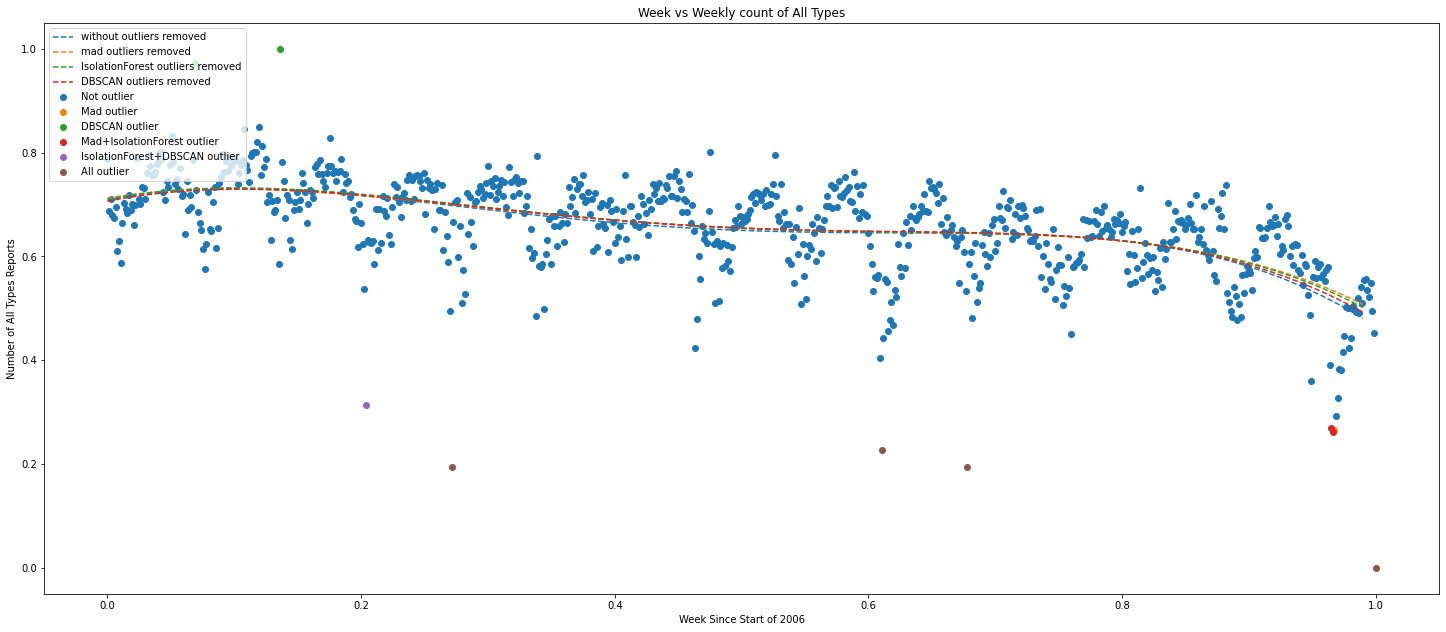

Detecting Outliers on: weeks vs ABORTION
Detecting Outliers on: weeks vs ADMINISTRATIVE CODE
target outlier count 10 vs 130 with MAD m: 1.66
target outlier count 10 vs 91 with MAD m: 1.8199999999999998
target outlier count 10 vs 91 with MAD m: 1.9799999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 10 vs 65 with MAD m: 2.1399999999999997
target outlier count 10 vs 42 with MAD m: 2.3
target outlier count 10 vs 42 with MAD m: 2.46
target outlier count 10 vs 26 with MAD m: 2.62
target outlier count 10 vs 18 with MAD m: 2.7800000000000002
target outlier count 10 vs 14 with MAD m: 2.9400000000000004
target outlier count 10 vs 14 with MAD m: 3.1000000000000005
target outlier count 10 vs 6 with MAD m: 3.2600000000000007
target outlier count 10 vs 6 with MAD m: 3

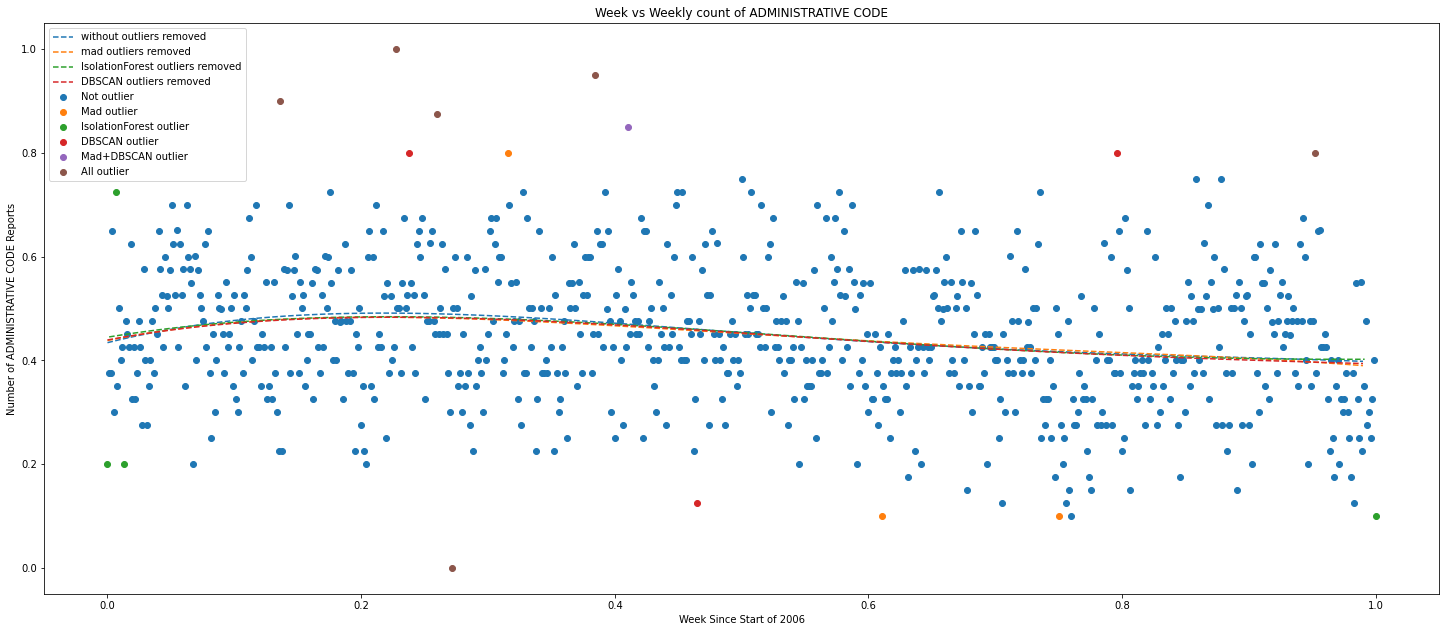

Detecting Outliers on: weeks vs ADMINISTRATIVE CODES
Detecting Outliers on: weeks vs AGRICULTURE & MRKTS LAW-UNCLASSIFIED
Detecting Outliers on: weeks vs ALCOHOLIC BEVERAGE CONTROL LAW
target outlier count 10 vs 98 with MAD m: 1.66
target outlier count 10 vs 98 with MAD m: 1.8199999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 10 vs 98 with MAD m: 1.9799999999999998
target outlier count 10 vs 58 with MAD m: 2.1399999999999997
target outlier count 10 vs 58 with MAD m: 2.3
target outlier count 10 vs 58 with MAD m: 2.46
target outlier count 10 vs 58 with MAD m: 2.62
target outlier count 10 vs 27 with MAD m: 2.7800000000000002
target outlier count 10 vs 27 with MAD m: 2.9400000000000004
target outlier count 10 vs 27 with MAD m: 3.1000000000000005
target outl

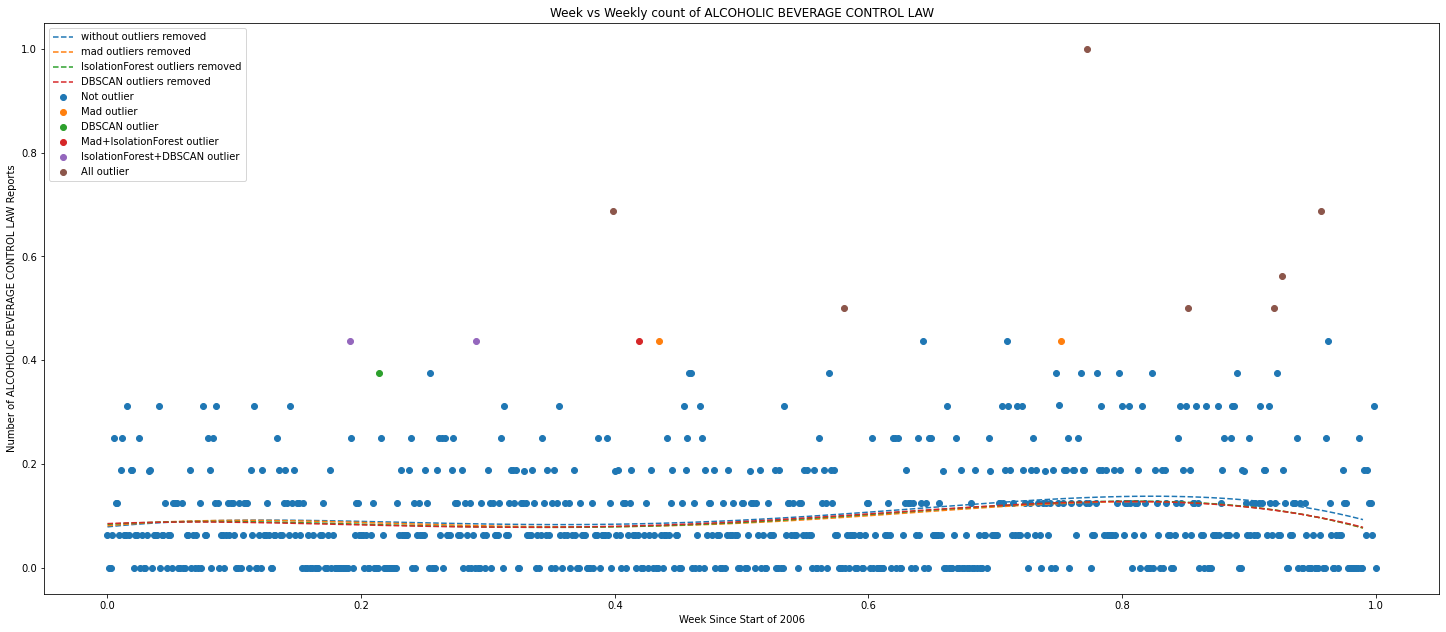

Detecting Outliers on: weeks vs ANTICIPATORY OFFENSES
Detecting Outliers on: weeks vs ARSON
target outlier count 10 vs 51 with MAD m: 1.66
target outlier count 10 vs 41 with MAD m: 1.8199999999999998
target outlier count 10 vs 34 with MAD m: 1.9799999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 10 vs 17 with MAD m: 2.1399999999999997
target outlier count 10 vs 14 with MAD m: 2.3
target outlier count 10 vs 10 with MAD m: 2.46
target outlier count 10 vs 376 with DBSCAN eps 0.02
target outlier count 10 vs 52 with DBSCAN eps 0.04
target outlier count 10 vs 23 with DBSCAN eps 0.06
target outlier count 10 vs 10 with DBSCAN eps 0.08
without outliers removed outlier count: 0
outlier week dates: 
None
without outliers removed r2: 0.5191498132263457
mad outliers 

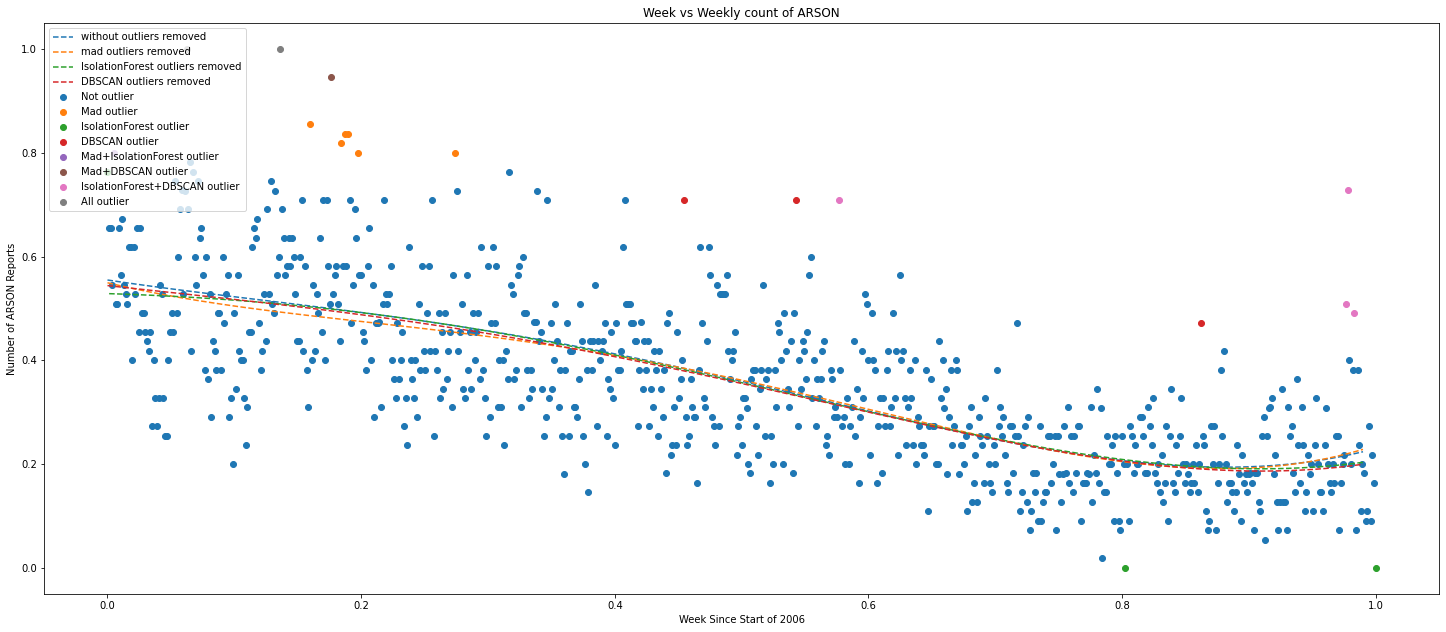

Detecting Outliers on: weeks vs ASSAULT 3 & RELATED OFFENSES
target outlier count 10 vs 42 with MAD m: 1.66
target outlier count 10 vs 30 with MAD m: 1.8199999999999998
target outlier count 10 vs 20 with MAD m: 1.9799999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 10 vs 15 with MAD m: 2.1399999999999997
target outlier count 10 vs 13 with MAD m: 2.3
target outlier count 10 vs 12 with MAD m: 2.46
target outlier count 10 vs 10 with MAD m: 2.62
target outlier count 10 vs 245 with DBSCAN eps 0.02
target outlier count 10 vs 30 with DBSCAN eps 0.04
target outlier count 10 vs 10 with DBSCAN eps 0.06
without outliers removed outlier count: 0
outlier week dates: 
None
without outliers removed r2: 0.0913277167556572
mad outliers removed outlier count: 10
outlier w

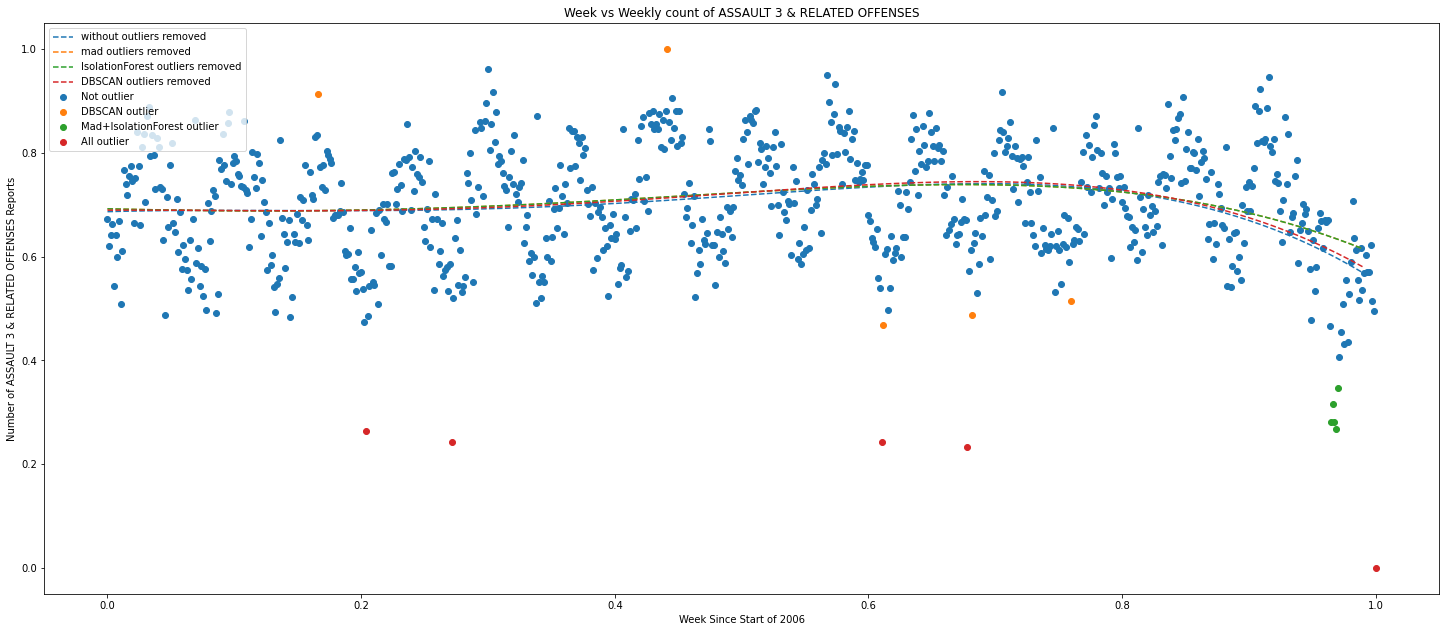

Detecting Outliers on: weeks vs BURGLAR'S TOOLS
target outlier count 10 vs 67 with MAD m: 1.66
target outlier count 10 vs 33 with MAD m: 1.8199999999999998
target outlier count 10 vs 33 with MAD m: 1.9799999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 10 vs 15 with MAD m: 2.1399999999999997
target outlier count 10 vs 15 with MAD m: 2.3
target outlier count 10 vs 6 with MAD m: 2.46
target outlier count 10 vs 6 with MAD m: 2.38
target outlier count 10 vs 15 with MAD m: 2.3
target outlier count 10 vs 15 with MAD m: 2.34
target outlier count 10 vs 6 with MAD m: 2.38
target outlier count 10 vs 15 with MAD m: 2.36
target outlier count 10 vs 6 with MAD m: 2.3699999999999997
target outlier count 10 vs 7 with MAD m: 2.3649999999999998
target outlier count 10 vs 

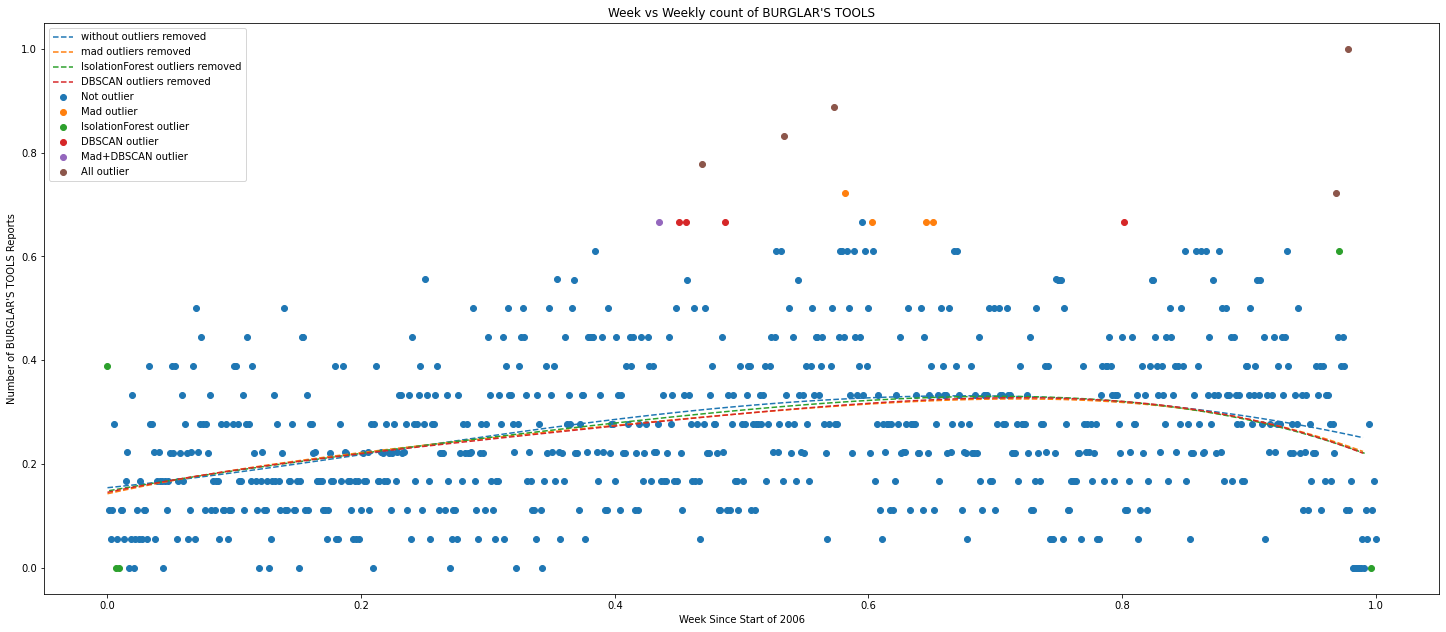

Detecting Outliers on: weeks vs BURGLARY
target outlier count 7 vs 10 with MAD m: 1.66
target outlier count 7 vs 8 with MAD m: 1.8199999999999998
target outlier count 7 vs 5 with MAD m: 1.9799999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 7 vs 5 with MAD m: 1.8999999999999997
target outlier count 7 vs 8 with MAD m: 1.8199999999999996
target outlier count 7 vs 7 with MAD m: 1.8599999999999997
target outlier count 7 vs 42 with DBSCAN eps 0.02
target outlier count 7 vs 8 with DBSCAN eps 0.04
target outlier count 7 vs 6 with DBSCAN eps 0.06
target outlier count 7 vs 6 with DBSCAN eps 0.049999999999999996
target outlier count 7 vs 8 with DBSCAN eps 0.039999999999999994
target outlier count 7 vs 7 with DBSCAN eps 0.04499999999999999
without outliers removed 

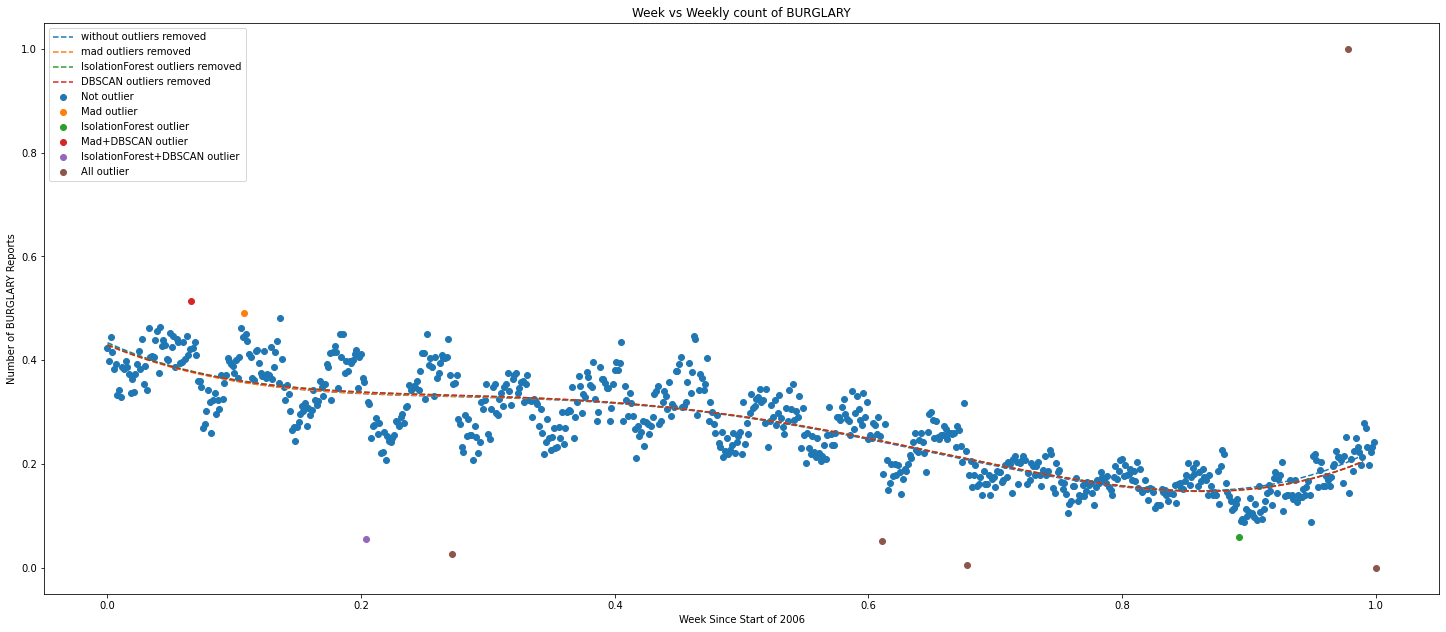

Detecting Outliers on: weeks vs CHILD ABANDONMENT/NON SUPPORT
Detecting Outliers on: weeks vs CRIMINAL MISCHIEF & RELATED OF
target outlier count 10 vs 67 with MAD m: 1.66
target outlier count 10 vs 47 with MAD m: 1.8199999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 10 vs 30 with MAD m: 1.9799999999999998
target outlier count 10 vs 25 with MAD m: 2.1399999999999997
target outlier count 10 vs 19 with MAD m: 2.3
target outlier count 10 vs 10 with MAD m: 2.46
target outlier count 10 vs 174 with DBSCAN eps 0.02
target outlier count 10 vs 38 with DBSCAN eps 0.04
target outlier count 10 vs 20 with DBSCAN eps 0.06
target outlier count 10 vs 10 with DBSCAN eps 0.08
without outliers removed outlier count: 0
outlier week dates: 
None
without outliers removed r2:

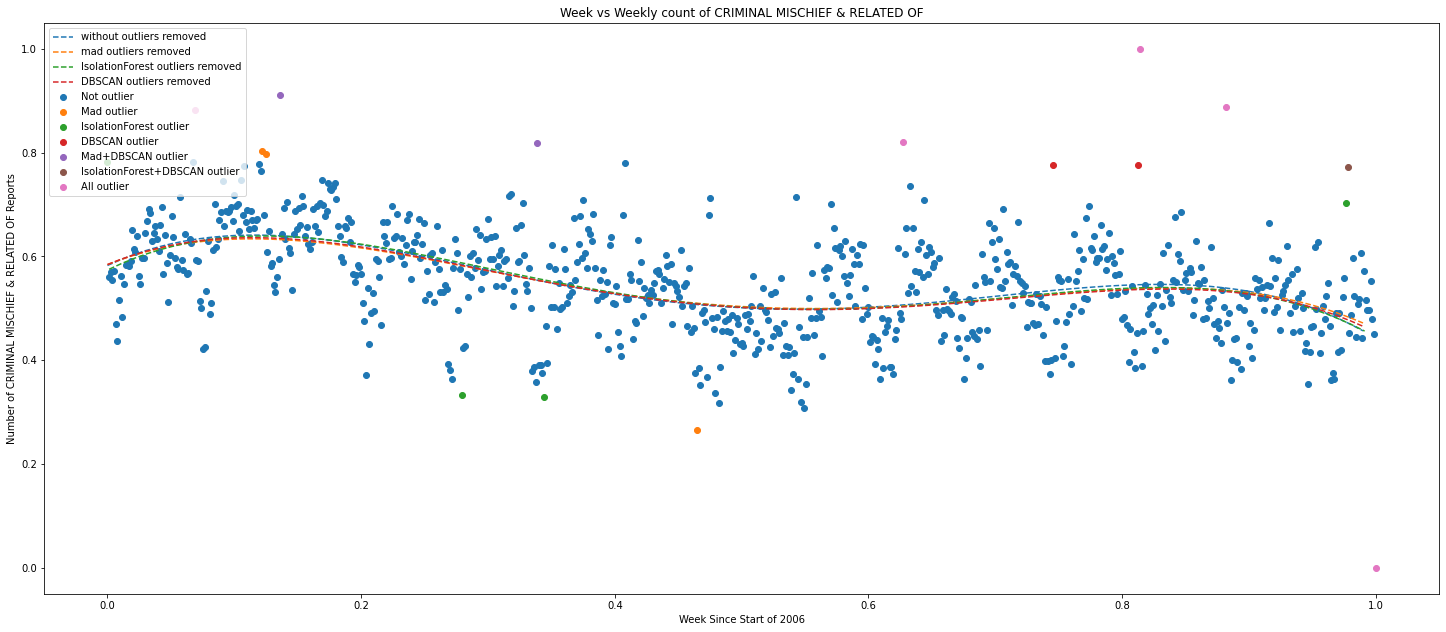

Detecting Outliers on: weeks vs CRIMINAL TRESPASS
target outlier count 10 vs 87 with MAD m: 1.66
target outlier count 10 vs 71 with MAD m: 1.8199999999999998
target outlier count 10 vs 61 with MAD m: 1.9799999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 10 vs 48 with MAD m: 2.1399999999999997
target outlier count 10 vs 40 with MAD m: 2.3
target outlier count 10 vs 35 with MAD m: 2.46
target outlier count 10 vs 28 with MAD m: 2.62
target outlier count 10 vs 23 with MAD m: 2.7800000000000002
target outlier count 10 vs 16 with MAD m: 2.9400000000000004
target outlier count 10 vs 13 with MAD m: 3.1000000000000005
target outlier count 10 vs 5 with MAD m: 3.2600000000000007
target outlier count 10 vs 12 with MAD m: 3.1800000000000006
target outlier count 10 v

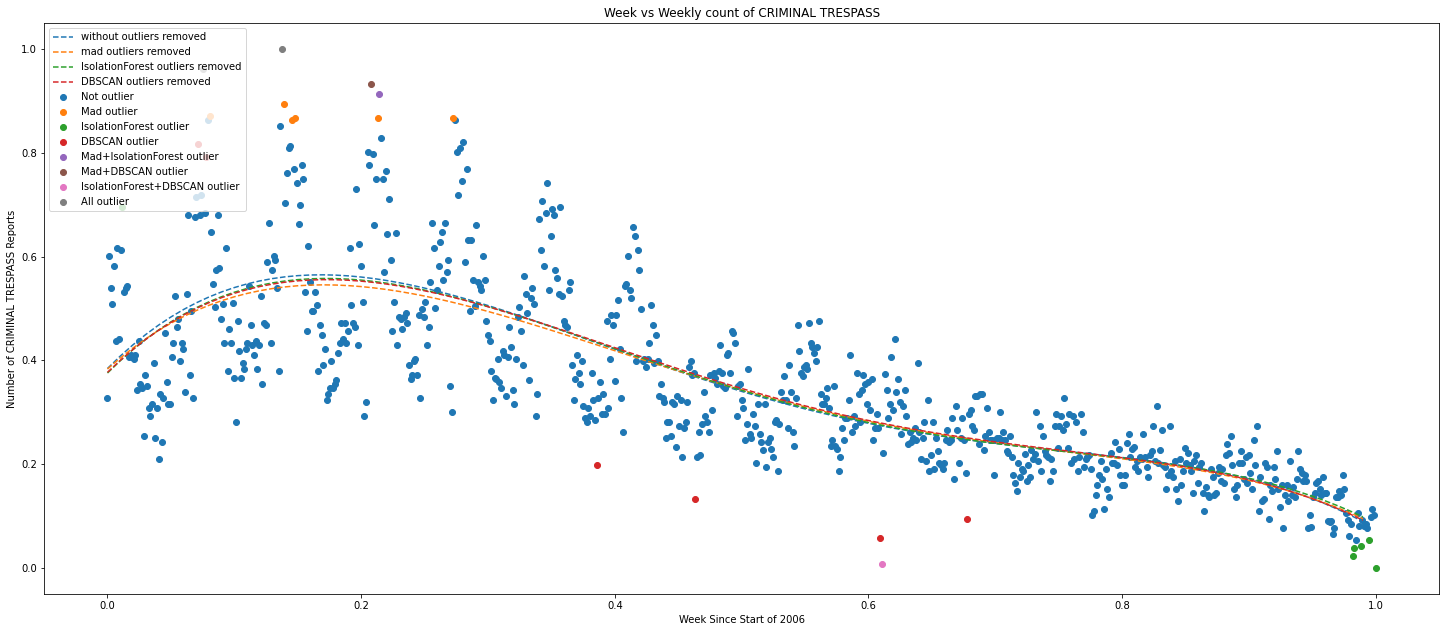

Detecting Outliers on: weeks vs DANGEROUS DRUGS
target outlier count 10 vs 37 with MAD m: 1.66
target outlier count 10 vs 24 with MAD m: 1.8199999999999998
target outlier count 10 vs 17 with MAD m: 1.9799999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 10 vs 12 with MAD m: 2.1399999999999997
target outlier count 10 vs 2 with MAD m: 2.3
target outlier count 10 vs 7 with MAD m: 2.2199999999999998
target outlier count 10 vs 12 with MAD m: 2.1399999999999997
target outlier count 10 vs 10 with MAD m: 2.1799999999999997
target outlier count 10 vs 244 with DBSCAN eps 0.02
target outlier count 10 vs 42 with DBSCAN eps 0.04
target outlier count 10 vs 19 with DBSCAN eps 0.06
target outlier count 10 vs 10 with DBSCAN eps 0.08
without outliers removed outlier count:

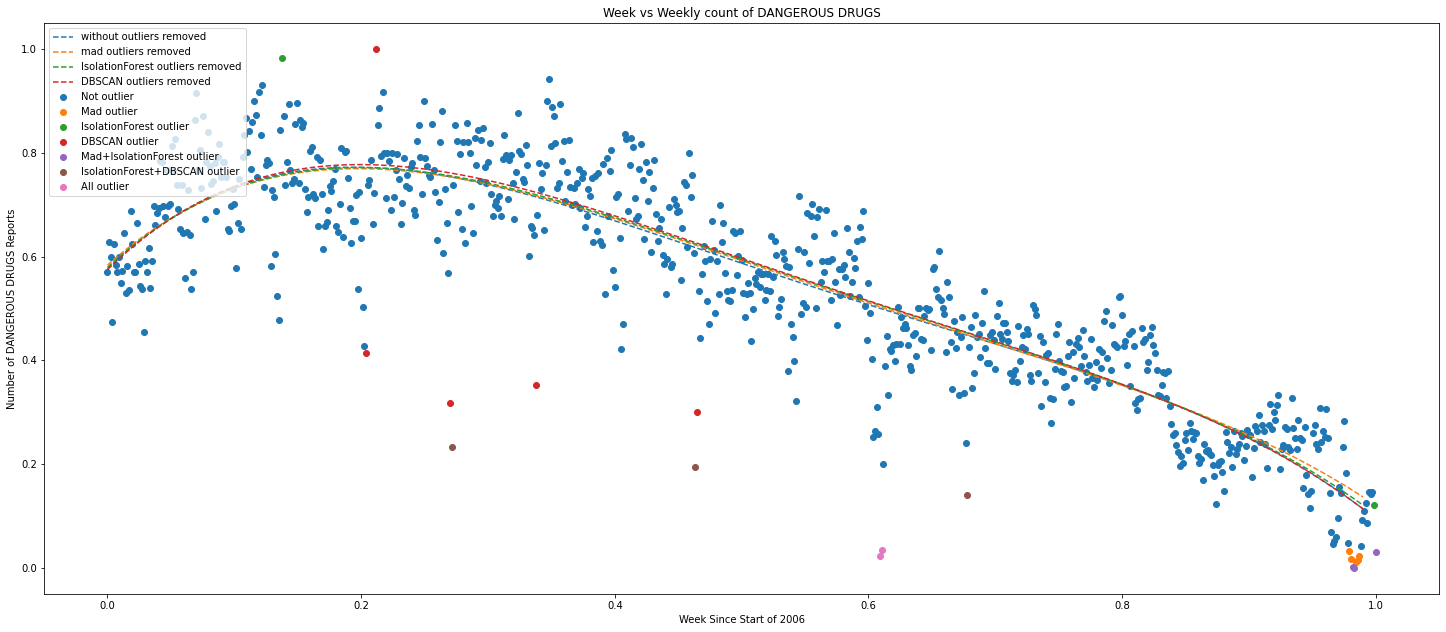

Detecting Outliers on: weeks vs DANGEROUS WEAPONS
target outlier count 10 vs 85 with MAD m: 1.66
target outlier count 10 vs 67 with MAD m: 1.8199999999999998
target outlier count 10 vs 51 with MAD m: 1.9799999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 10 vs 38 with MAD m: 2.1399999999999997
target outlier count 10 vs 22 with MAD m: 2.3
target outlier count 10 vs 16 with MAD m: 2.46
target outlier count 10 vs 11 with MAD m: 2.62
target outlier count 10 vs 9 with MAD m: 2.7800000000000002
target outlier count 10 vs 9 with MAD m: 2.7
target outlier count 10 vs 11 with MAD m: 2.62
target outlier count 10 vs 10 with MAD m: 2.66
target outlier count 10 vs 286 with DBSCAN eps 0.02
target outlier count 10 vs 39 with DBSCAN eps 0.04
target outlier count 10 vs 

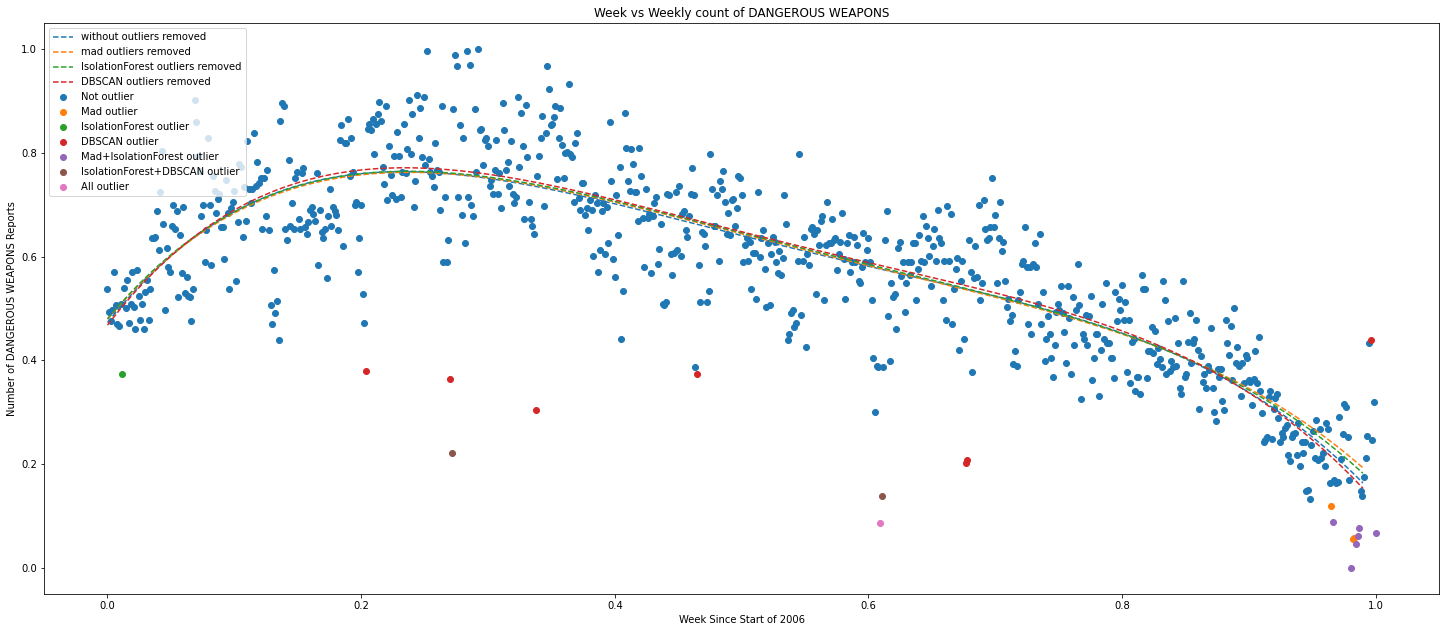

Detecting Outliers on: weeks vs DISORDERLY CONDUCT
target outlier count 10 vs 80 with MAD m: 1.66
target outlier count 10 vs 80 with MAD m: 1.8199999999999998
target outlier count 10 vs 80 with MAD m: 1.9799999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 10 vs 47 with MAD m: 2.1399999999999997
target outlier count 10 vs 47 with MAD m: 2.3
target outlier count 10 vs 47 with MAD m: 2.46
target outlier count 10 vs 47 with MAD m: 2.62
target outlier count 10 vs 24 with MAD m: 2.7800000000000002
target outlier count 10 vs 24 with MAD m: 2.9400000000000004
target outlier count 10 vs 24 with MAD m: 3.1000000000000005
target outlier count 10 vs 24 with MAD m: 3.2600000000000007
target outlier count 10 vs 11 with MAD m: 3.420000000000001
target outlier count 10 

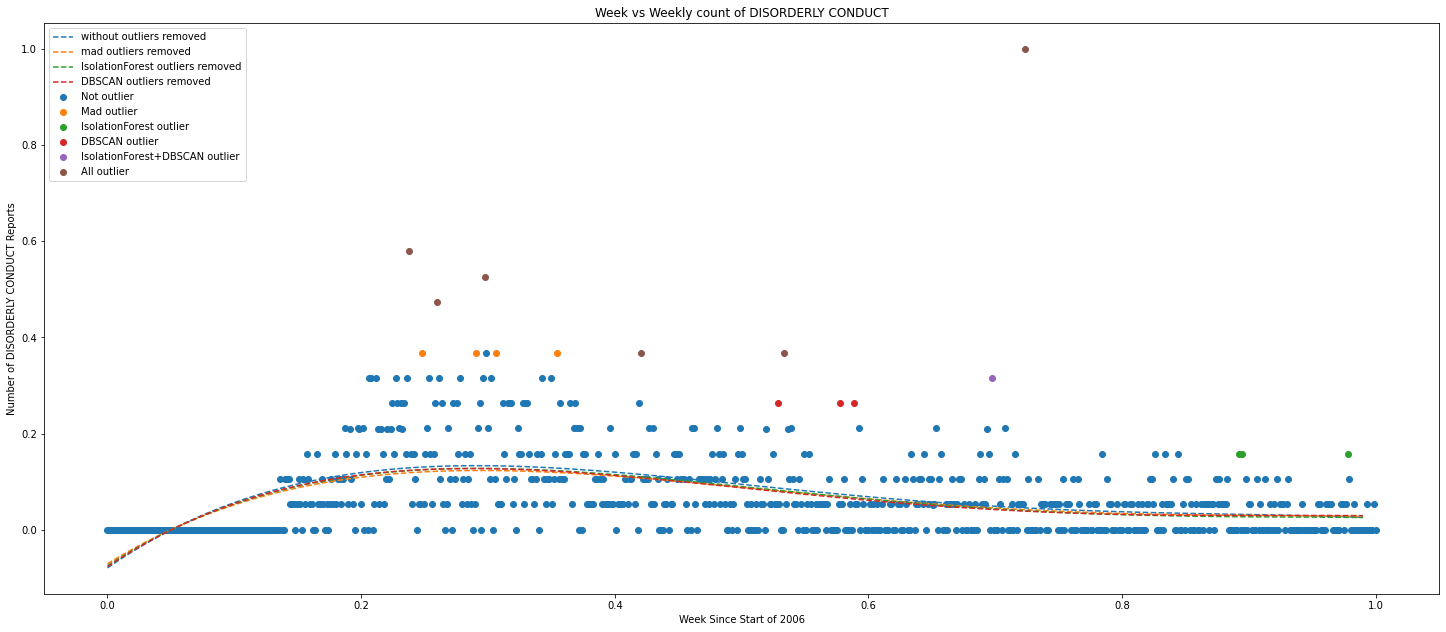

Detecting Outliers on: weeks vs DISRUPTION OF A RELIGIOUS SERV
Detecting Outliers on: weeks vs ENDAN WELFARE INCOMP
Detecting Outliers on: weeks vs ESCAPE 3
Detecting Outliers on: weeks vs FELONY ASSAULT
target outlier count 10 vs 61 with MAD m: 1.66
target outlier count 10 vs 38 with MAD m: 1.8199999999999998
target outlier count 10 vs 24 with MAD m: 1.9799999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 10 vs 15 with MAD m: 2.1399999999999997
target outlier count 10 vs 12 with MAD m: 2.3
target outlier count 10 vs 7 with MAD m: 2.46
target outlier count 10 vs 9 with MAD m: 2.38
target outlier count 10 vs 12 with MAD m: 2.3
target outlier count 10 vs 10 with MAD m: 2.34
target outlier count 10 vs 325 with DBSCAN eps 0.02
target outlier count 10 vs 50 wi

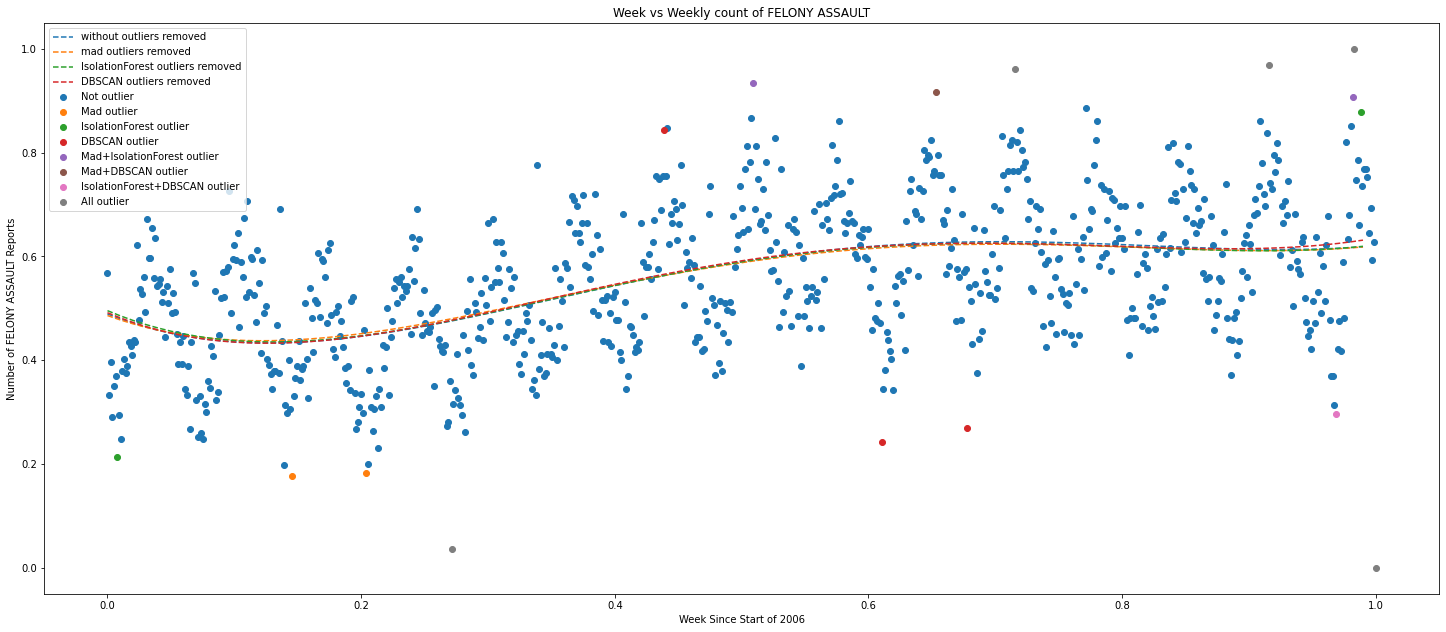

Detecting Outliers on: weeks vs FELONY SEX CRIMES
Detecting Outliers on: weeks vs FORGERY
target outlier count 10 vs 75 with MAD m: 1.66
target outlier count 10 vs 61 with MAD m: 1.8199999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 10 vs 48 with MAD m: 1.9799999999999998
target outlier count 10 vs 40 with MAD m: 2.1399999999999997
target outlier count 10 vs 38 with MAD m: 2.3
target outlier count 10 vs 34 with MAD m: 2.46
target outlier count 10 vs 31 with MAD m: 2.62
target outlier count 10 vs 28 with MAD m: 2.7800000000000002
target outlier count 10 vs 21 with MAD m: 2.9400000000000004
target outlier count 10 vs 20 with MAD m: 3.1000000000000005
target outlier count 10 vs 16 with MAD m: 3.2600000000000007
target outlier count 10 vs 10 with MAD m: 3.4

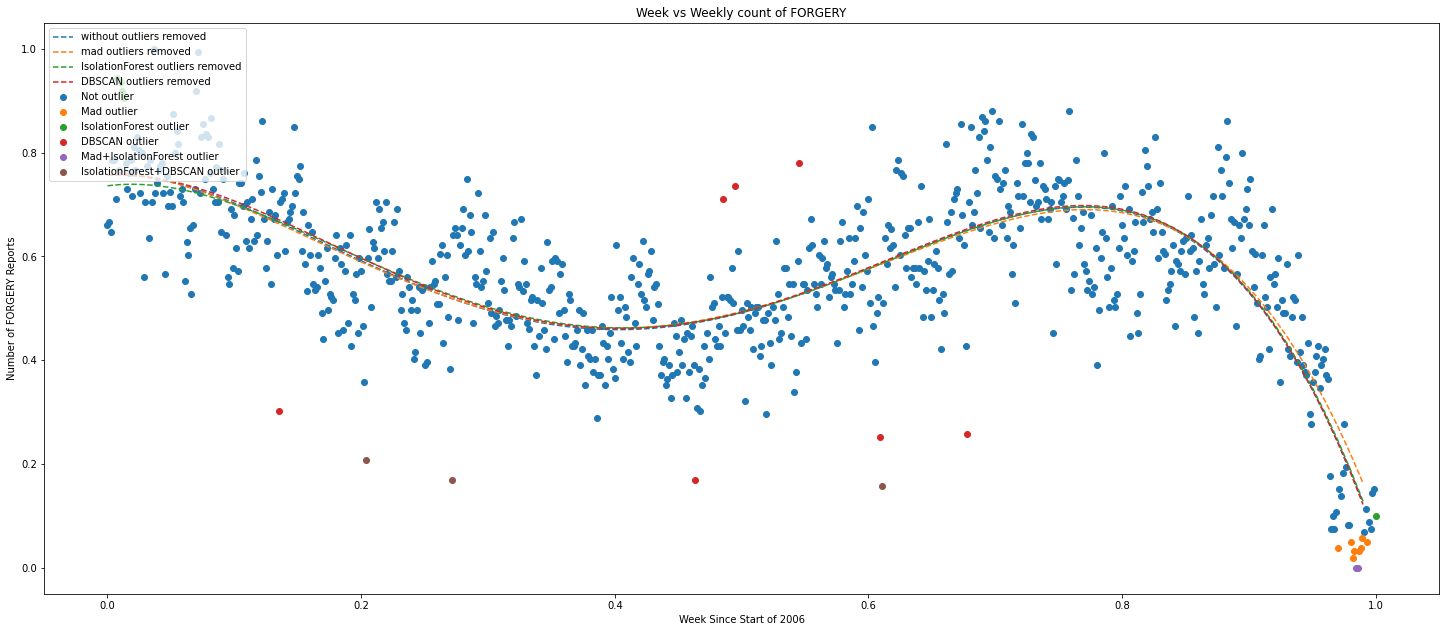

Detecting Outliers on: weeks vs FORTUNE TELLING
Detecting Outliers on: weeks vs FRAUDS
target outlier count 10 vs 98 with MAD m: 1.66
target outlier count 10 vs 83 with MAD m: 1.8199999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 10 vs 66 with MAD m: 1.9799999999999998
target outlier count 10 vs 58 with MAD m: 2.1399999999999997
target outlier count 10 vs 44 with MAD m: 2.3
target outlier count 10 vs 37 with MAD m: 2.46
target outlier count 10 vs 26 with MAD m: 2.62
target outlier count 10 vs 19 with MAD m: 2.7800000000000002
target outlier count 10 vs 15 with MAD m: 2.9400000000000004
target outlier count 10 vs 11 with MAD m: 3.1000000000000005
target outlier count 10 vs 9 with MAD m: 3.2600000000000007
target outlier count 10 vs 10 with MAD m: 3.18000

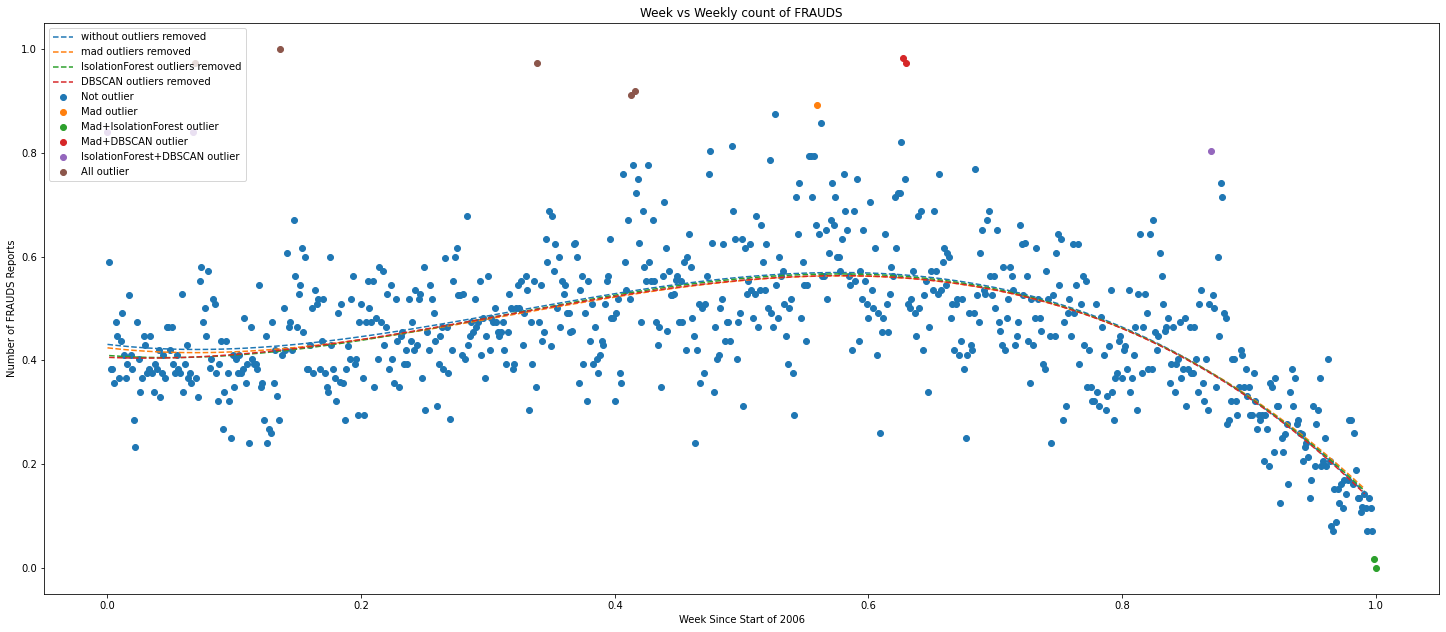

Detecting Outliers on: weeks vs FRAUDULENT ACCOSTING
target outlier count 7 vs 62 with MAD m: 1.66
target outlier count 7 vs 41 with MAD m: 1.8199999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 7 vs 41 with MAD m: 1.9799999999999998
target outlier count 7 vs 22 with MAD m: 2.1399999999999997
target outlier count 7 vs 22 with MAD m: 2.3
target outlier count 7 vs 13 with MAD m: 2.46
target outlier count 7 vs 13 with MAD m: 2.62
target outlier count 7 vs 9 with MAD m: 2.7800000000000002
target outlier count 7 vs 9 with MAD m: 2.9400000000000004
target outlier count 7 vs 7 with MAD m: 3.1000000000000005
target outlier count 7 vs 261 with DBSCAN eps 0.02
target outlier count 7 vs 97 with DBSCAN eps 0.04
target outlier count 7 vs 22 with DBSCAN eps 0.06
targe

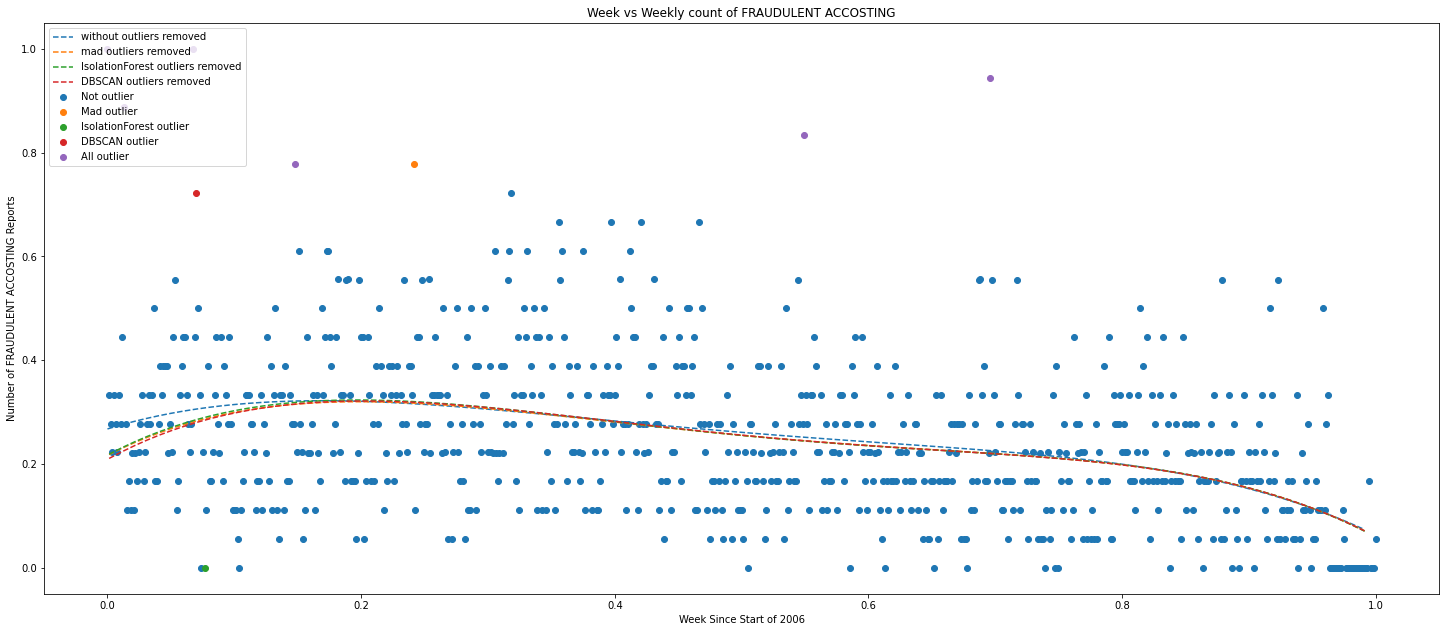

Detecting Outliers on: weeks vs GAMBLING
target outlier count 10 vs 99 with MAD m: 1.66
target outlier count 10 vs 71 with MAD m: 1.8199999999999998
target outlier count 10 vs 71 with MAD m: 1.9799999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 10 vs 50 with MAD m: 2.1399999999999997
target outlier count 10 vs 50 with MAD m: 2.3
target outlier count 10 vs 39 with MAD m: 2.46
target outlier count 10 vs 39 with MAD m: 2.62
target outlier count 10 vs 27 with MAD m: 2.7800000000000002
target outlier count 10 vs 27 with MAD m: 2.9400000000000004
target outlier count 10 vs 17 with MAD m: 3.1000000000000005
target outlier count 10 vs 17 with MAD m: 3.2600000000000007
target outlier count 10 vs 10 with MAD m: 3.420000000000001
target outlier count 10 vs 246 wit

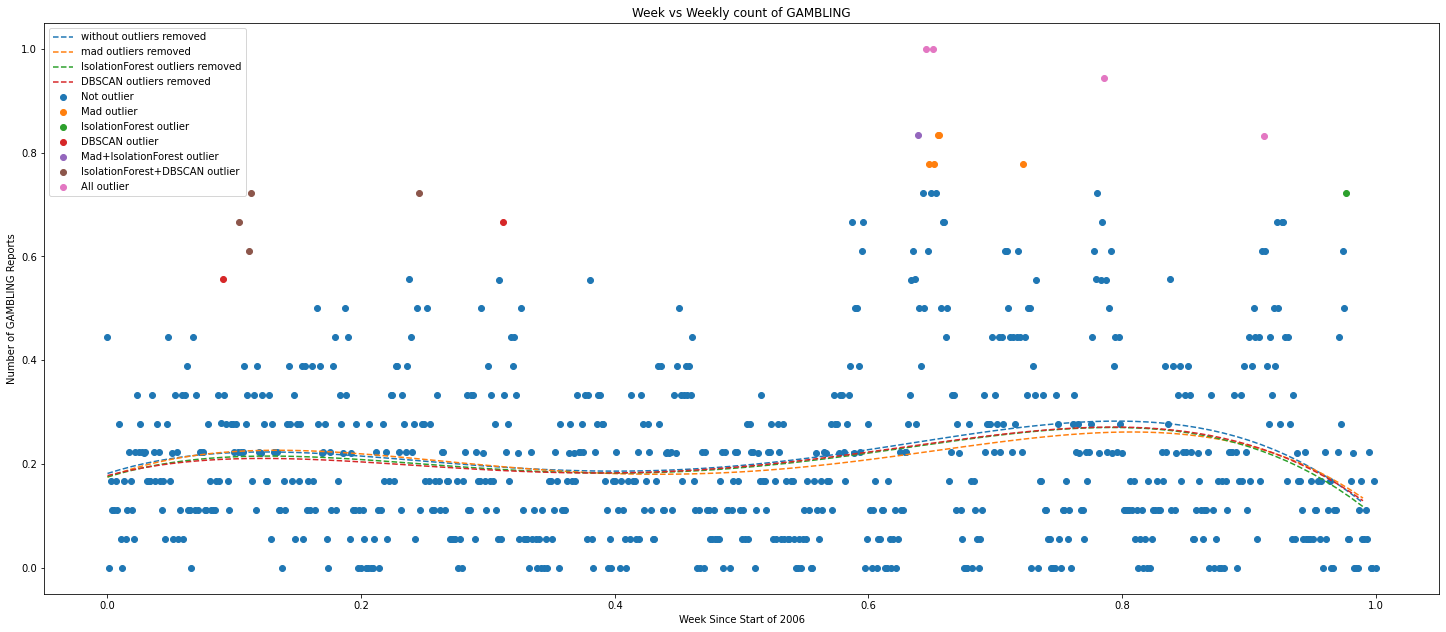

Detecting Outliers on: weeks vs GRAND LARCENY
target outlier count 10 vs 73 with MAD m: 1.66
target outlier count 10 vs 59 with MAD m: 1.8199999999999998
target outlier count 10 vs 46 with MAD m: 1.9799999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 10 vs 41 with MAD m: 2.1399999999999997
target outlier count 10 vs 38 with MAD m: 2.3
target outlier count 10 vs 33 with MAD m: 2.46
target outlier count 10 vs 32 with MAD m: 2.62
target outlier count 10 vs 27 with MAD m: 2.7800000000000002
target outlier count 10 vs 23 with MAD m: 2.9400000000000004
target outlier count 10 vs 21 with MAD m: 3.1000000000000005
target outlier count 10 vs 19 with MAD m: 3.2600000000000007
target outlier count 10 vs 17 with MAD m: 3.420000000000001
target outlier count 10 vs 13

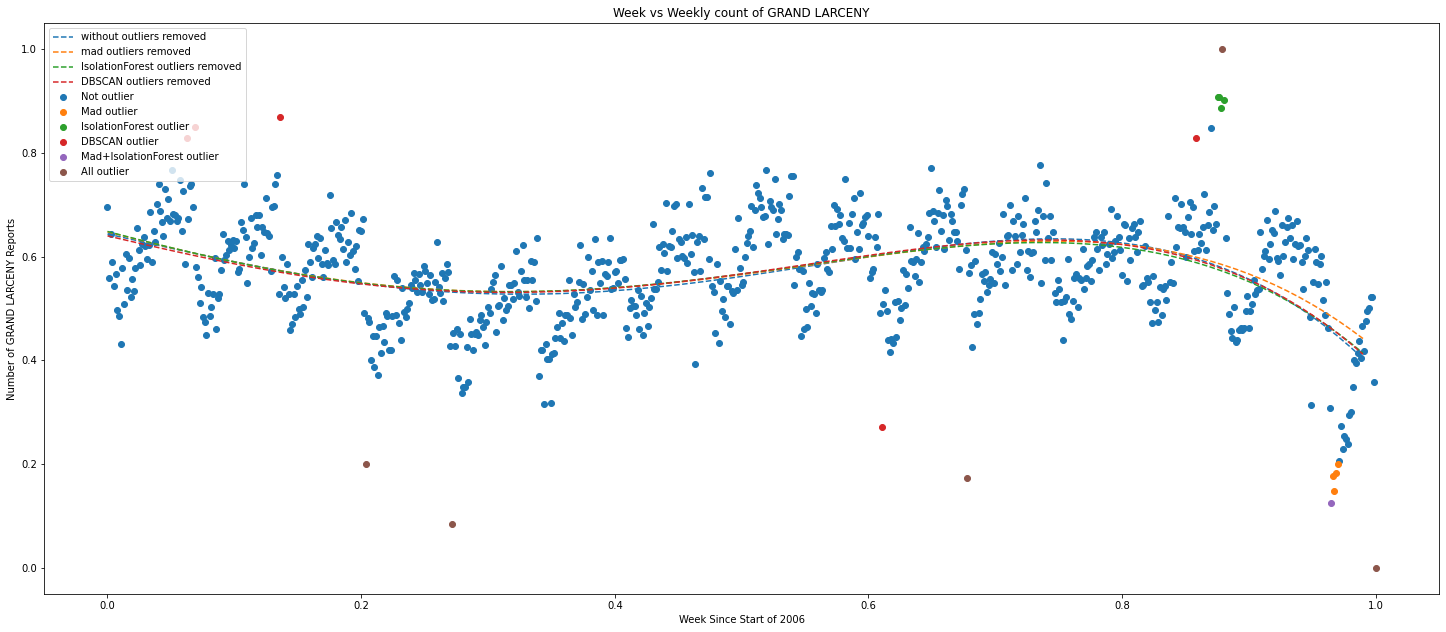

Detecting Outliers on: weeks vs GRAND LARCENY OF MOTOR VEHICLE
target outlier count 9 vs 89 with MAD m: 1.66
target outlier count 9 vs 69 with MAD m: 1.8199999999999998
target outlier count 9 vs 55 with MAD m: 1.9799999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 9 vs 38 with MAD m: 2.1399999999999997
target outlier count 9 vs 26 with MAD m: 2.3
target outlier count 9 vs 17 with MAD m: 2.46
target outlier count 9 vs 16 with MAD m: 2.62
target outlier count 9 vs 12 with MAD m: 2.7800000000000002
target outlier count 9 vs 8 with MAD m: 2.9400000000000004
target outlier count 9 vs 9 with MAD m: 2.8600000000000003
target outlier count 9 vs 197 with DBSCAN eps 0.02
target outlier count 9 vs 30 with DBSCAN eps 0.04
target outlier count 9 vs 7 with DBSCAN eps 

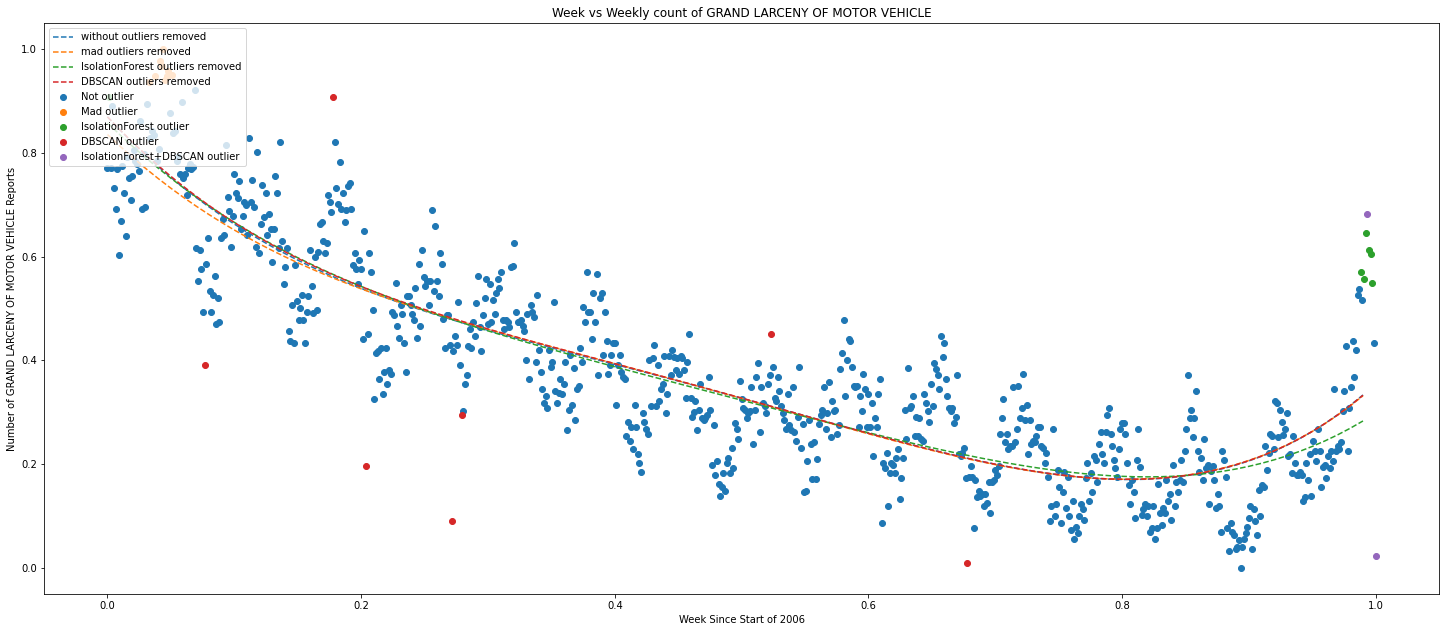

Detecting Outliers on: weeks vs HARRASSMENT 2
target outlier count 9 vs 42 with MAD m: 1.66
target outlier count 9 vs 23 with MAD m: 1.8199999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 9 vs 13 with MAD m: 1.9799999999999998
target outlier count 9 vs 8 with MAD m: 2.1399999999999997
target outlier count 9 vs 9 with MAD m: 2.0599999999999996
target outlier count 9 vs 255 with DBSCAN eps 0.02
target outlier count 9 vs 30 with DBSCAN eps 0.04
target outlier count 9 vs 8 with DBSCAN eps 0.06
target outlier count 9 vs 14 with DBSCAN eps 0.049999999999999996
target outlier count 9 vs 11 with DBSCAN eps 0.05499999999999999
target outlier count 9 vs 8 with DBSCAN eps 0.05999999999999999
target outlier count 9 vs 9 with DBSCAN eps 0.05749999999999999
without ou

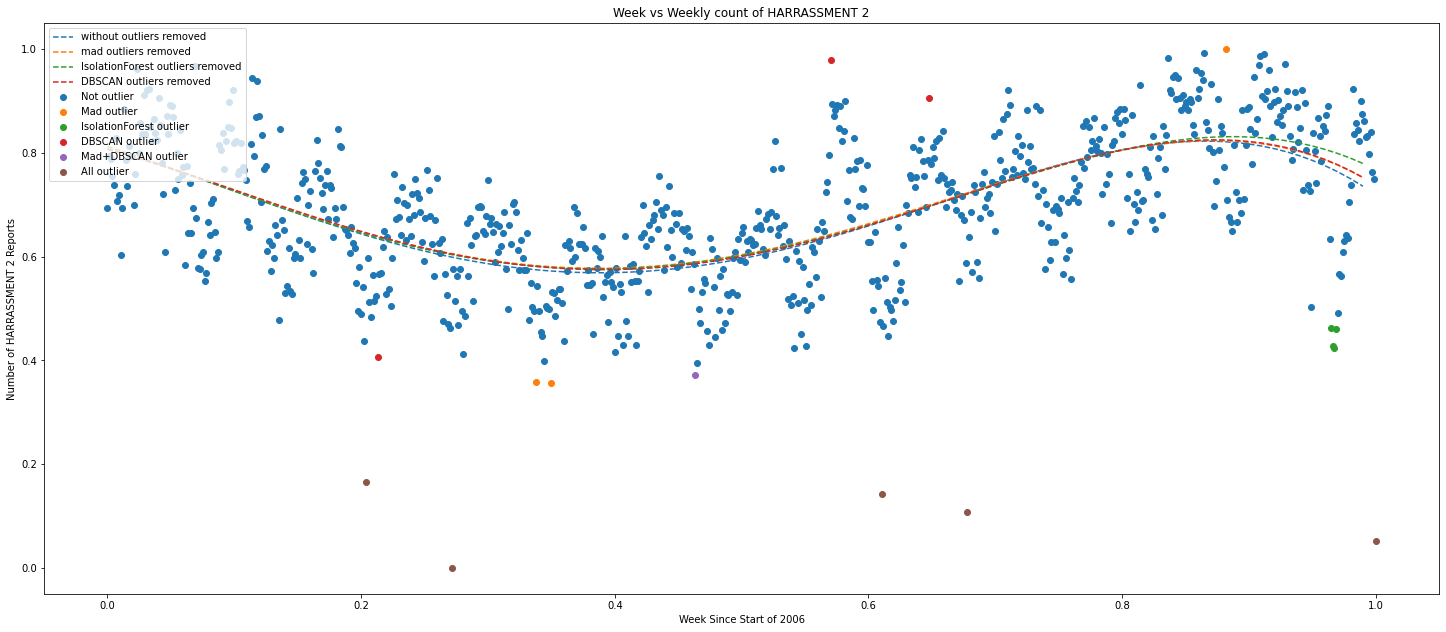

Detecting Outliers on: weeks vs HOMICIDE-NEGLIGENT,UNCLASSIFIE
Detecting Outliers on: weeks vs HOMICIDE-NEGLIGENT-VEHICLE
Detecting Outliers on: weeks vs INTOXICATED & IMPAIRED DRIVING
target outlier count 10 vs 73 with MAD m: 1.66
target outlier count 10 vs 58 with MAD m: 1.8199999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 10 vs 41 with MAD m: 1.9799999999999998
target outlier count 10 vs 33 with MAD m: 2.1399999999999997
target outlier count 10 vs 28 with MAD m: 2.3
target outlier count 10 vs 25 with MAD m: 2.46
target outlier count 10 vs 18 with MAD m: 2.62
target outlier count 10 vs 11 with MAD m: 2.7800000000000002
target outlier count 10 vs 6 with MAD m: 2.9400000000000004
target outlier count 10 vs 7 with MAD m: 2.8600000000000003
target outlie

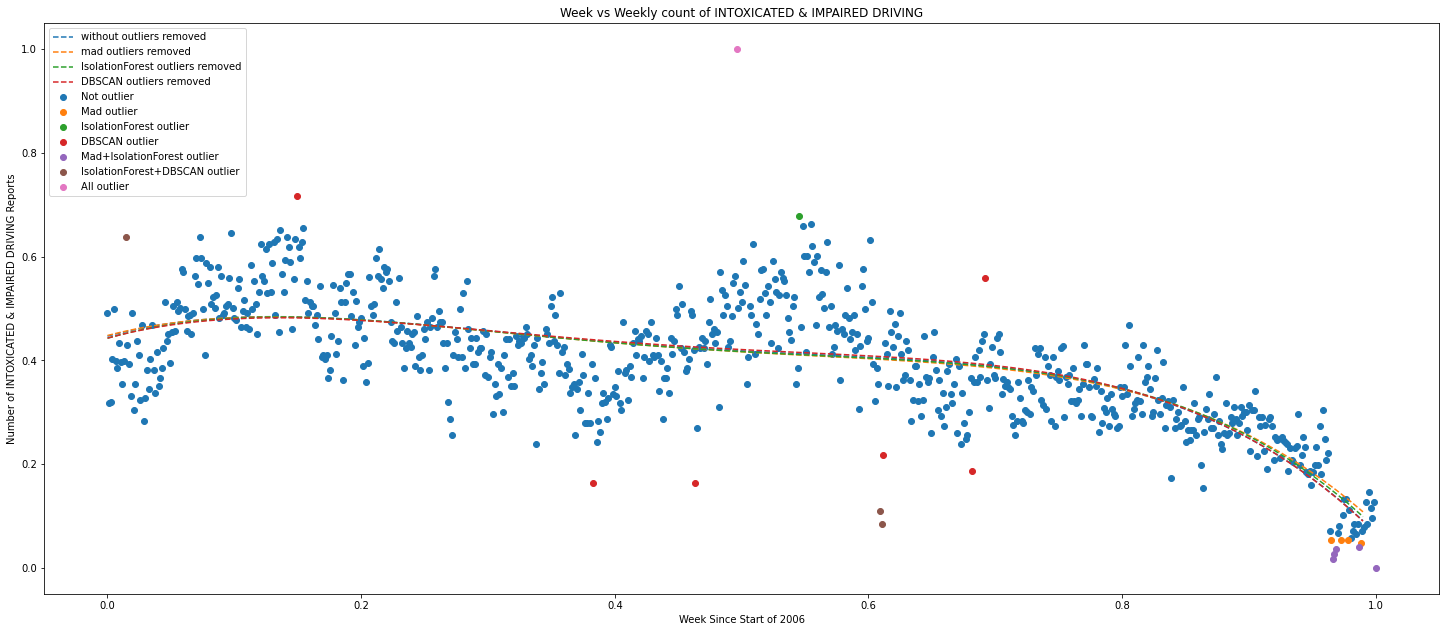

Detecting Outliers on: weeks vs INTOXICATED/IMPAIRED DRIVING
Detecting Outliers on: weeks vs JOSTLING
Detecting Outliers on: weeks vs KIDNAPPING
Detecting Outliers on: weeks vs KIDNAPPING & RELATED OFFENSES
target outlier count 10 vs 197 with MAD m: 1.66
target outlier count 10 vs 197 with MAD m: 1.8199999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 10 vs 197 with MAD m: 1.9799999999999998
target outlier count 10 vs 96 with MAD m: 2.1399999999999997
target outlier count 10 vs 96 with MAD m: 2.3
target outlier count 10 vs 96 with MAD m: 2.46
target outlier count 10 vs 96 with MAD m: 2.62
target outlier count 10 vs 57 with MAD m: 2.7800000000000002
target outlier count 10 vs 57 with MAD m: 2.9400000000000004
target outlier count 10 vs 57 with MAD m: 3.100

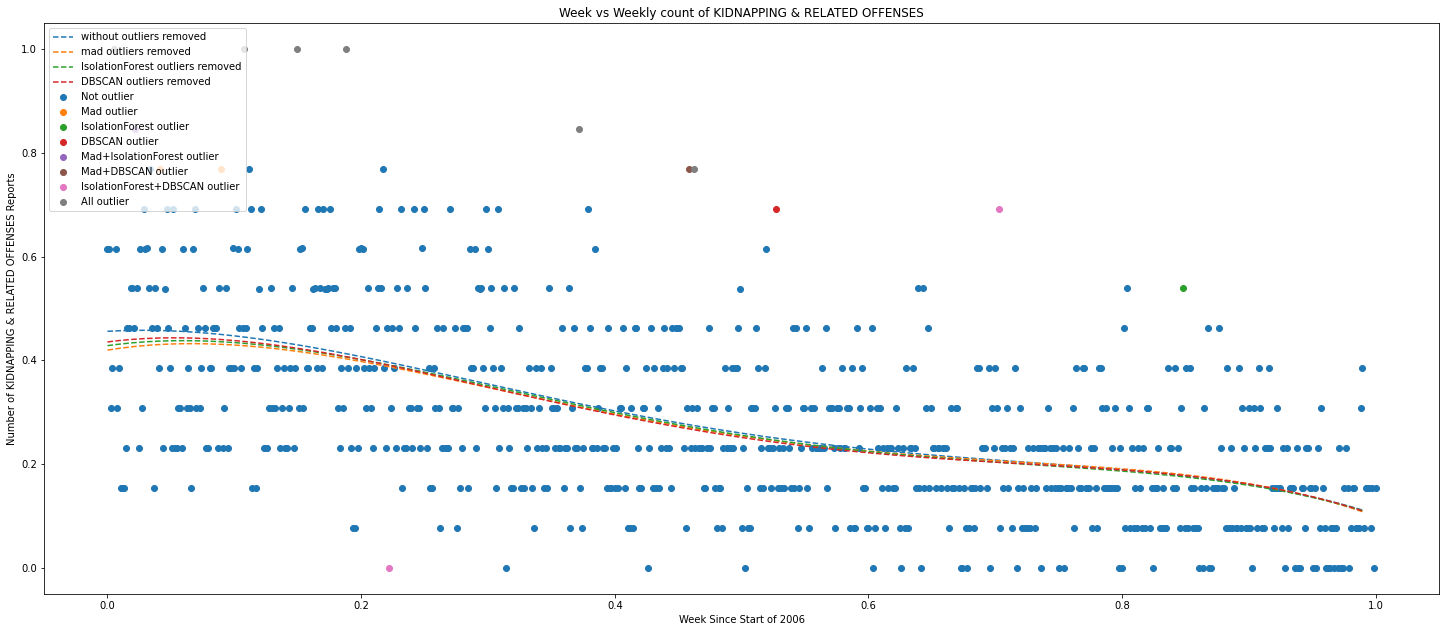

Detecting Outliers on: weeks vs KIDNAPPING AND RELATED OFFENSES
Detecting Outliers on: weeks vs LOITERING
Detecting Outliers on: weeks vs LOITERING FOR DRUG PURPOSES
Detecting Outliers on: weeks vs LOITERING/DEVIATE SEX
Detecting Outliers on: weeks vs LOITERING/GAMBLING (CARDS, DIC
Detecting Outliers on: weeks vs MISCELLANEOUS PENAL LAW
target outlier count 10 vs 45 with MAD m: 1.66
target outlier count 10 vs 29 with MAD m: 1.8199999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 10 vs 20 with MAD m: 1.9799999999999998
target outlier count 10 vs 13 with MAD m: 2.1399999999999997
target outlier count 10 vs 10 with MAD m: 2.3
target outlier count 10 vs 323 with DBSCAN eps 0.02
target outlier count 10 vs 52 with DBSCAN eps 0.04
target outlier count 10 vs 27 w

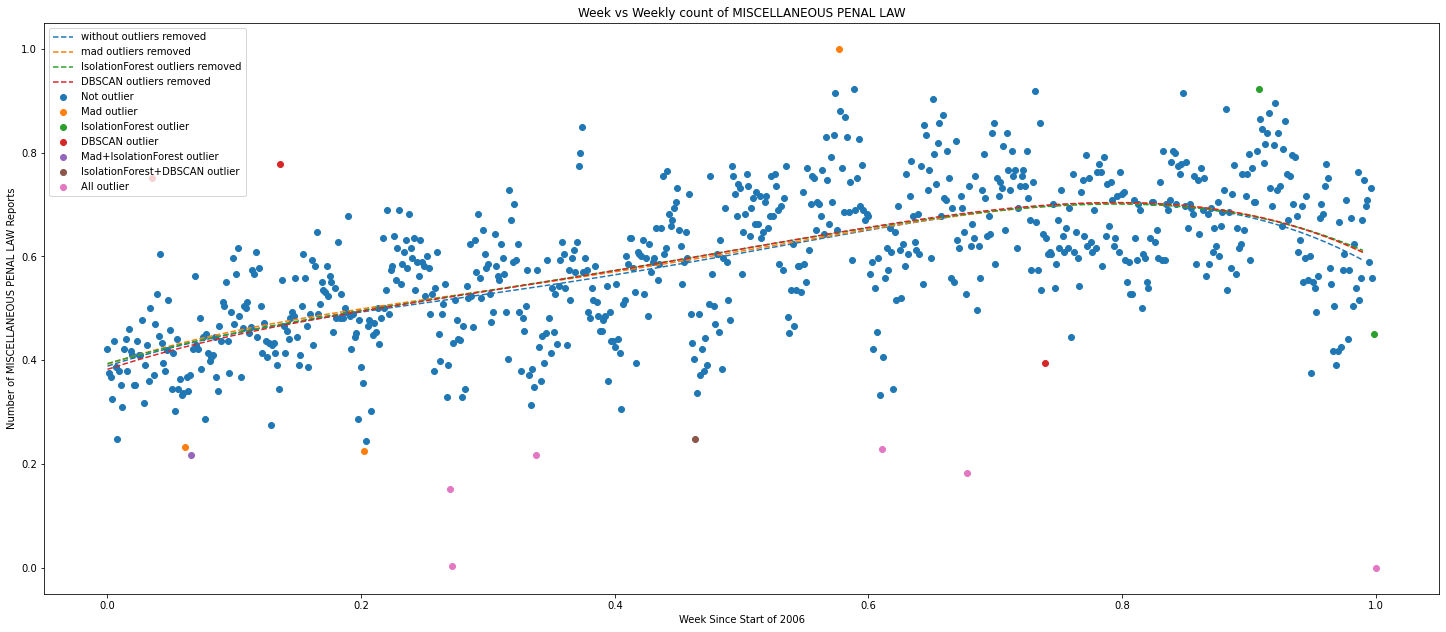

Detecting Outliers on: weeks vs MURDER & NON-NEGL. MANSLAUGHTER
target outlier count 10 vs 182 with MAD m: 1.66
target outlier count 10 vs 113 with MAD m: 1.8199999999999998
target outlier count 10 vs 113 with MAD m: 1.9799999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 10 vs 70 with MAD m: 2.1399999999999997
target outlier count 10 vs 70 with MAD m: 2.3
target outlier count 10 vs 43 with MAD m: 2.46
target outlier count 10 vs 43 with MAD m: 2.62
target outlier count 10 vs 28 with MAD m: 2.7800000000000002
target outlier count 10 vs 28 with MAD m: 2.9400000000000004
target outlier count 10 vs 18 with MAD m: 3.1000000000000005
target outlier count 10 vs 18 with MAD m: 3.2600000000000007
target outlier count 10 vs 10 with MAD m: 3.420000000000001
target o

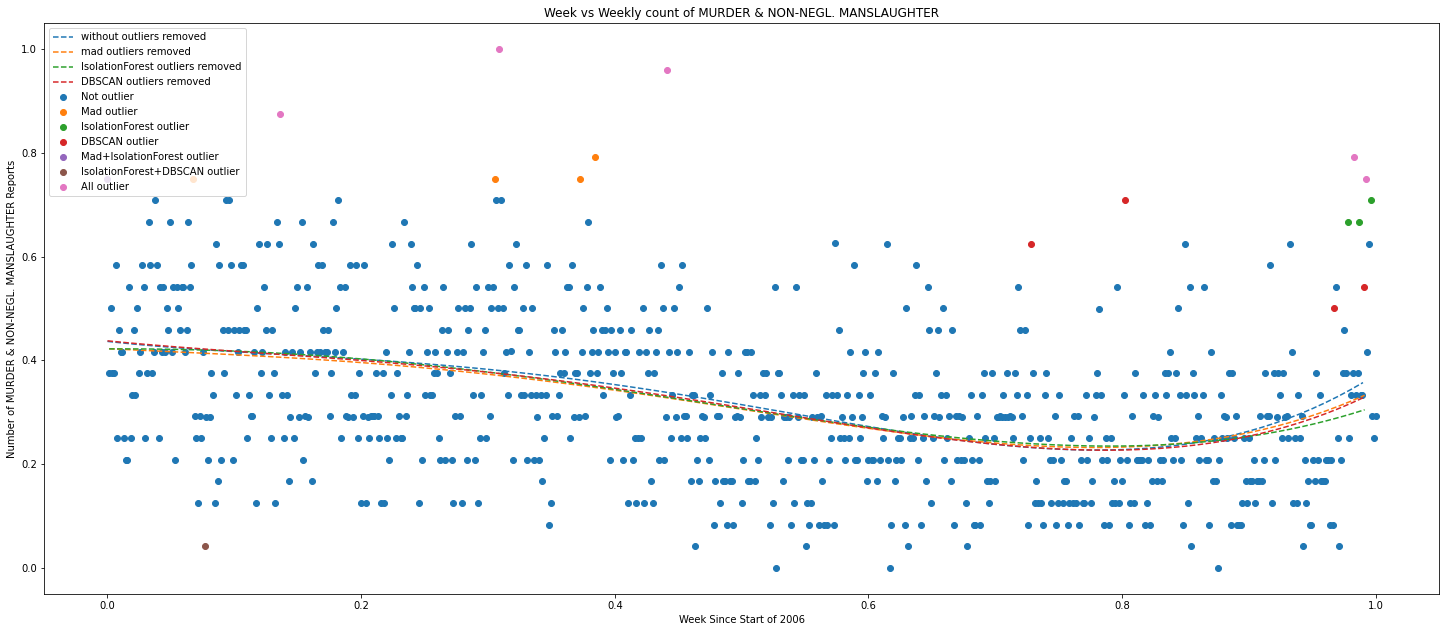

Detecting Outliers on: weeks vs NEW YORK CITY HEALTH CODE
Detecting Outliers on: weeks vs NYS LAWS-UNCLASSIFIED FELONY
target outlier count 10 vs 55 with MAD m: 1.66
target outlier count 10 vs 41 with MAD m: 1.8199999999999998
target outlier count 10 vs 41 with MAD m: 1.9799999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 10 vs 28 with MAD m: 2.1399999999999997
target outlier count 10 vs 16 with MAD m: 2.3
target outlier count 10 vs 16 with MAD m: 2.46
target outlier count 10 vs 12 with MAD m: 2.62
target outlier count 10 vs 9 with MAD m: 2.7800000000000002
target outlier count 10 vs 12 with MAD m: 2.7
target outlier count 10 vs 9 with MAD m: 2.74
target outlier count 10 vs 9 with MAD m: 2.72
target outlier count 10 vs 12 with MAD m: 2.7
target outlier c

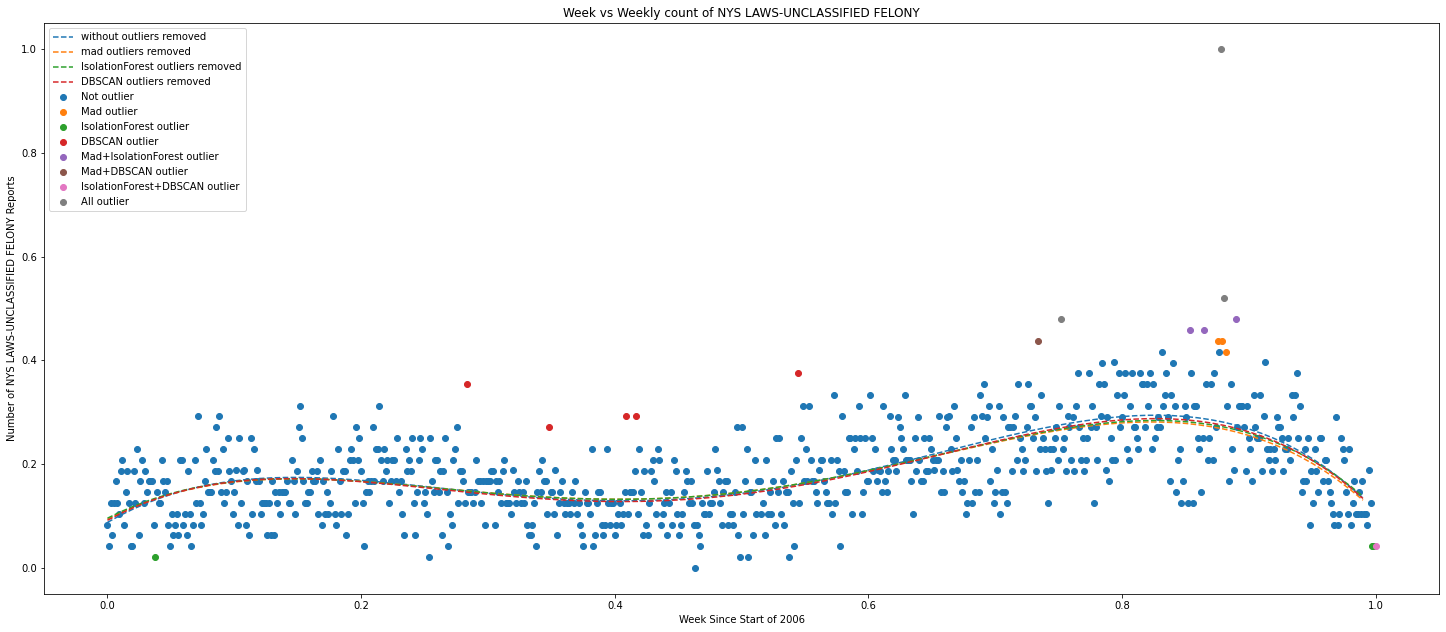

Detecting Outliers on: weeks vs NYS LAWS-UNCLASSIFIED VIOLATION
Detecting Outliers on: weeks vs OFF. AGNST PUB ORD SENSBLTY &
target outlier count 10 vs 42 with MAD m: 1.66
target outlier count 10 vs 28 with MAD m: 1.8199999999999998
target outlier count 10 vs 19 with MAD m: 1.9799999999999998
target outlier count 10 vs 8 with MAD m: 2.1399999999999997
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 10 vs 15 with MAD m: 2.0599999999999996
target outlier count 10 vs 11 with MAD m: 2.0999999999999996
target outlier count 10 vs 8 with MAD m: 2.1399999999999997
target outlier count 10 vs 9 with MAD m: 2.1199999999999997
target outlier count 10 vs 11 with MAD m: 2.0999999999999996
target outlier count 10 vs 11 with MAD m: 2.1099999999999994
target outlier count 10 vs 9 w

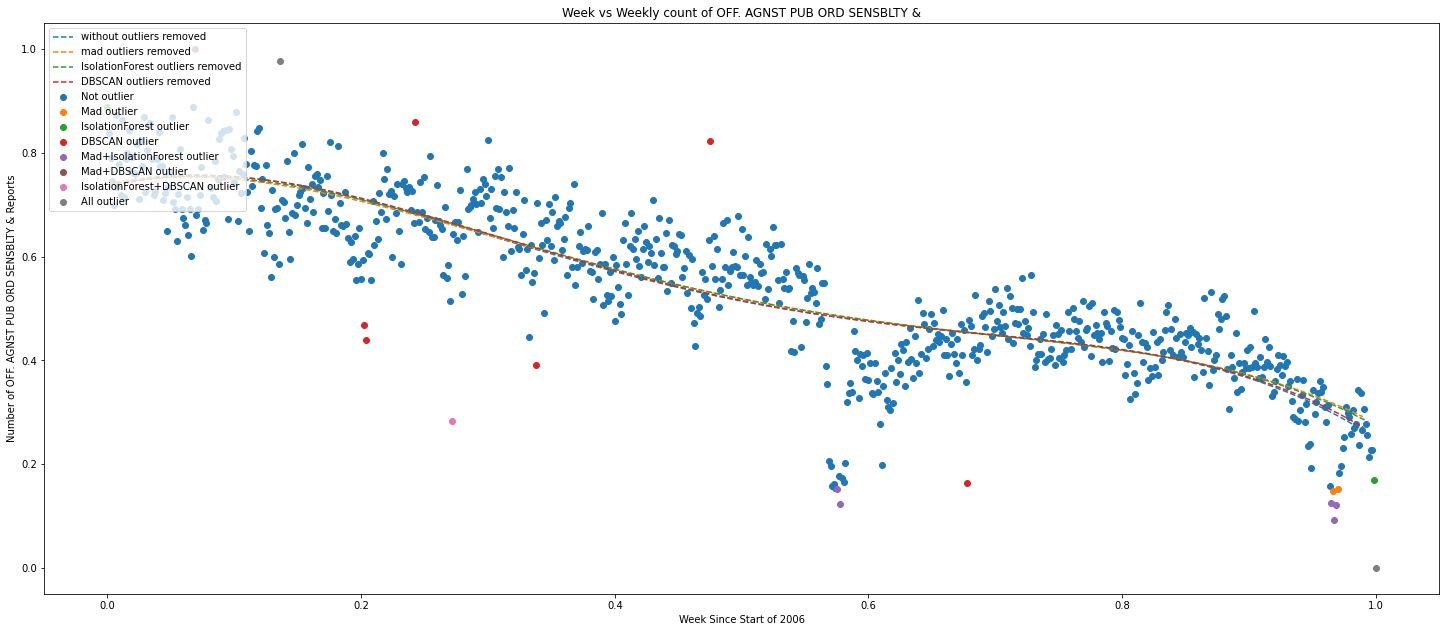

Detecting Outliers on: weeks vs OFFENSES AGAINST MARRIAGE UNCL
Detecting Outliers on: weeks vs OFFENSES AGAINST PUBLIC ADMINI
target outlier count 10 vs 61 with MAD m: 1.66
target outlier count 10 vs 41 with MAD m: 1.8199999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 10 vs 20 with MAD m: 1.9799999999999998
target outlier count 10 vs 17 with MAD m: 2.1399999999999997
target outlier count 10 vs 6 with MAD m: 2.3
target outlier count 10 vs 11 with MAD m: 2.2199999999999998
target outlier count 10 vs 7 with MAD m: 2.26
target outlier count 10 vs 10 with MAD m: 2.2399999999999998
target outlier count 10 vs 305 with DBSCAN eps 0.02
target outlier count 10 vs 49 with DBSCAN eps 0.04
target outlier count 10 vs 12 with DBSCAN eps 0.06
target outlier count 10 vs

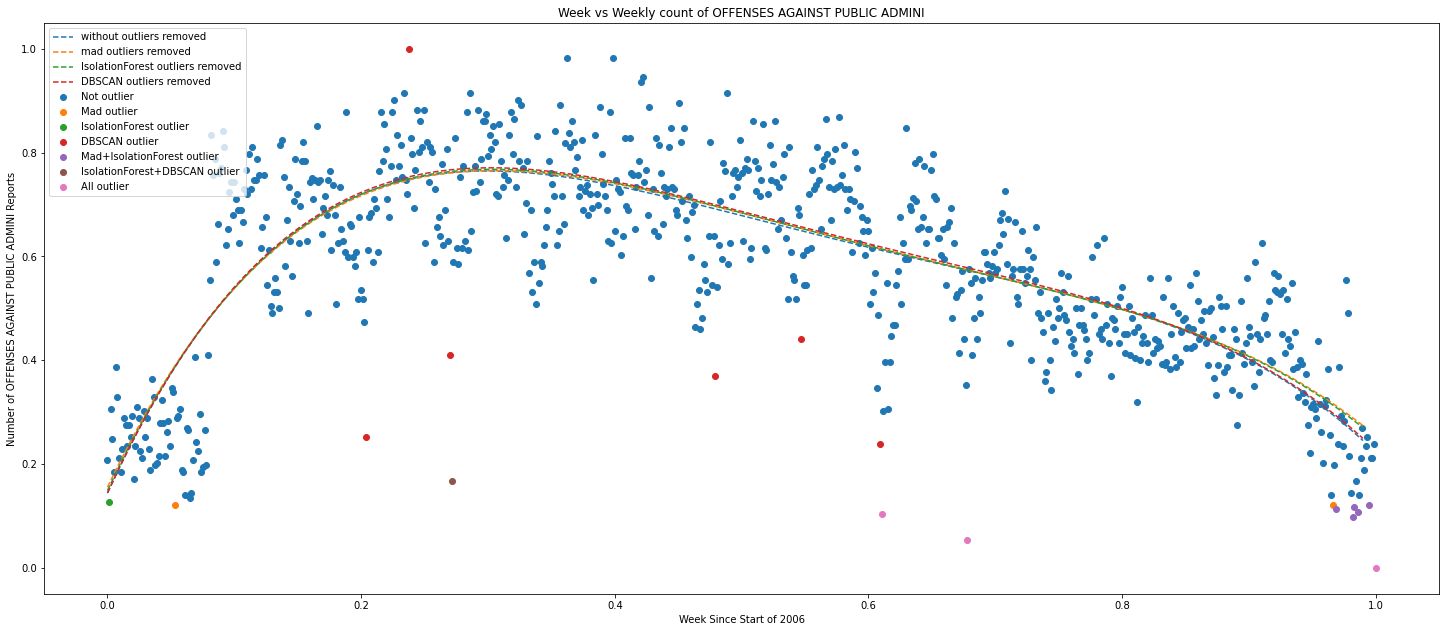

Detecting Outliers on: weeks vs OFFENSES AGAINST PUBLIC SAFETY
target outlier count 10 vs 47 with MAD m: 1.66
target outlier count 10 vs 47 with MAD m: 1.8199999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 10 vs 47 with MAD m: 1.9799999999999998
target outlier count 10 vs 31 with MAD m: 2.1399999999999997
target outlier count 10 vs 31 with MAD m: 2.3
target outlier count 10 vs 31 with MAD m: 2.46
target outlier count 10 vs 31 with MAD m: 2.62
target outlier count 10 vs 25 with MAD m: 2.7800000000000002
target outlier count 10 vs 25 with MAD m: 2.9400000000000004
target outlier count 10 vs 25 with MAD m: 3.1000000000000005
target outlier count 10 vs 25 with MAD m: 3.2600000000000007
target outlier count 10 vs 22 with MAD m: 3.420000000000001
target outli

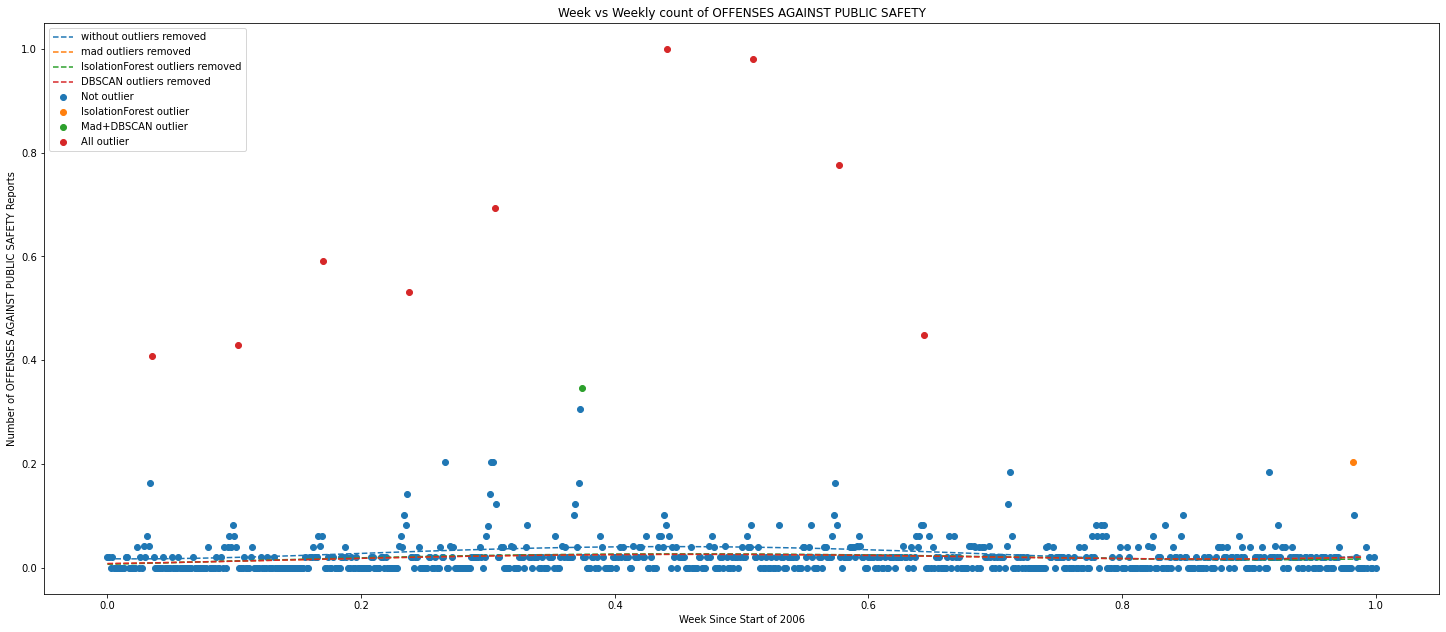

Detecting Outliers on: weeks vs OFFENSES AGAINST THE PERSON
target outlier count 10 vs 60 with MAD m: 1.66
target outlier count 10 vs 51 with MAD m: 1.8199999999999998
target outlier count 10 vs 37 with MAD m: 1.9799999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 10 vs 31 with MAD m: 2.1399999999999997
target outlier count 10 vs 20 with MAD m: 2.3
target outlier count 10 vs 19 with MAD m: 2.46
target outlier count 10 vs 16 with MAD m: 2.62
target outlier count 10 vs 16 with MAD m: 2.7800000000000002
target outlier count 10 vs 14 with MAD m: 2.9400000000000004
target outlier count 10 vs 14 with MAD m: 3.1000000000000005
target outlier count 10 vs 13 with MAD m: 3.2600000000000007
target outlier count 10 vs 12 with MAD m: 3.420000000000001
target outlier 

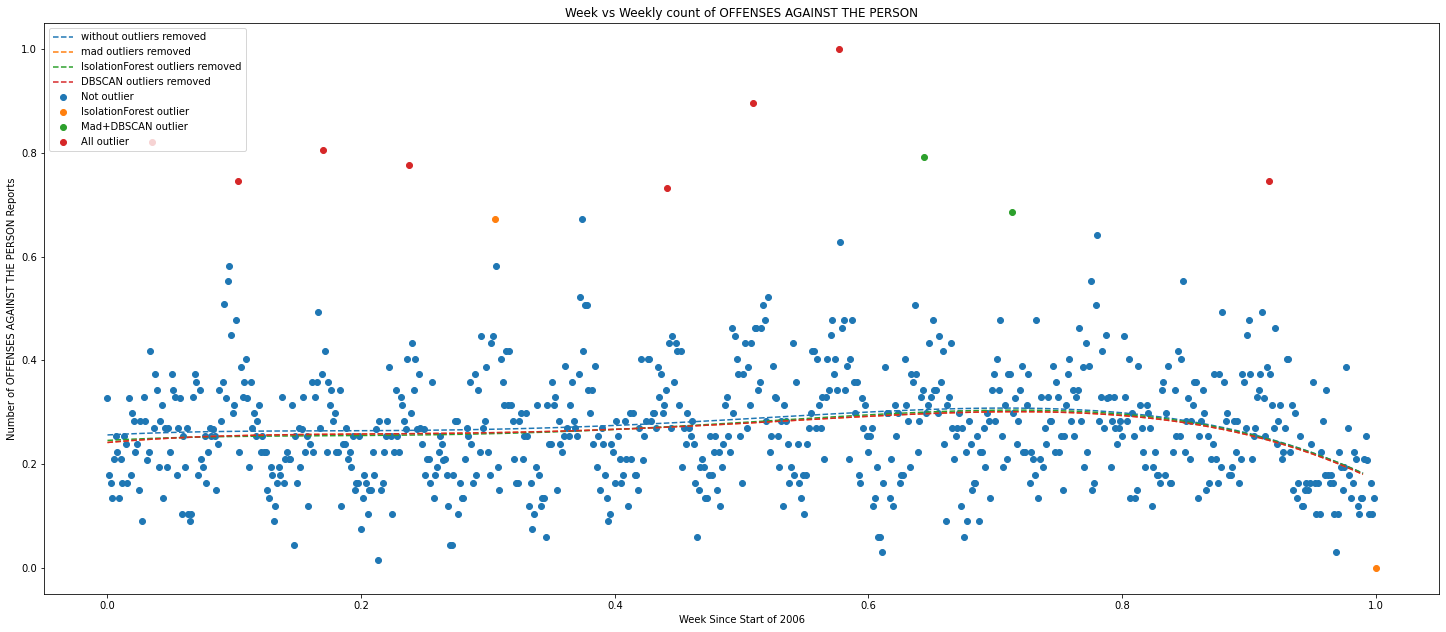

Detecting Outliers on: weeks vs OFFENSES INVOLVING FRAUD
target outlier count 10 vs 80 with MAD m: 1.66
target outlier count 10 vs 65 with MAD m: 1.8199999999999998
target outlier count 10 vs 45 with MAD m: 1.9799999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 10 vs 32 with MAD m: 2.1399999999999997
target outlier count 10 vs 23 with MAD m: 2.3
target outlier count 10 vs 11 with MAD m: 2.46
target outlier count 10 vs 10 with MAD m: 2.62
target outlier count 10 vs 384 with DBSCAN eps 0.02
target outlier count 10 vs 79 with DBSCAN eps 0.04
target outlier count 10 vs 11 with DBSCAN eps 0.06
target outlier count 10 vs 4 with DBSCAN eps 0.08
target outlier count 10 vs 7 with DBSCAN eps 0.07
target outlier count 10 vs 11 with DBSCAN eps 0.060000000000000005
t

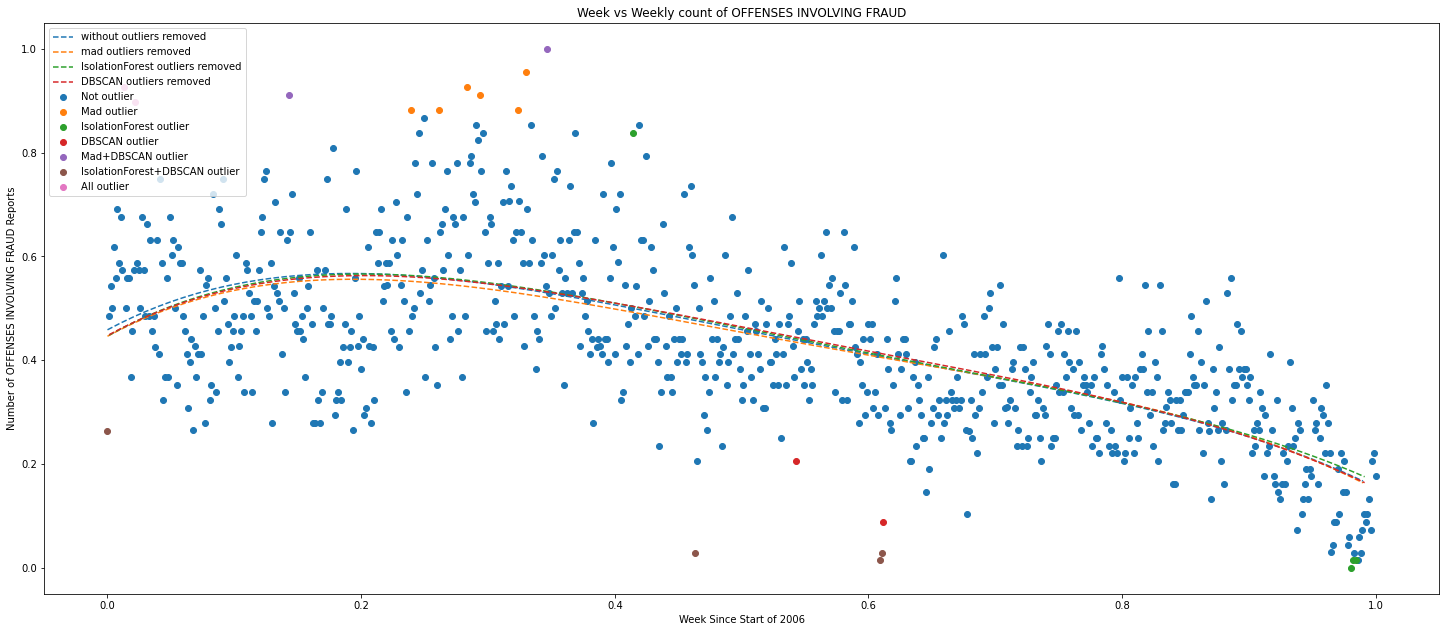

Detecting Outliers on: weeks vs OFFENSES RELATED TO CHILDREN
target outlier count 10 vs 181 with MAD m: 1.66
target outlier count 10 vs 181 with MAD m: 1.8199999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 10 vs 181 with MAD m: 1.9799999999999998
target outlier count 10 vs 135 with MAD m: 2.1399999999999997
target outlier count 10 vs 135 with MAD m: 2.3
target outlier count 10 vs 135 with MAD m: 2.46
target outlier count 10 vs 135 with MAD m: 2.62
target outlier count 10 vs 93 with MAD m: 2.7800000000000002
target outlier count 10 vs 93 with MAD m: 2.9400000000000004
target outlier count 10 vs 93 with MAD m: 3.1000000000000005
target outlier count 10 vs 93 with MAD m: 3.2600000000000007
target outlier count 10 vs 74 with MAD m: 3.420000000000001
target 

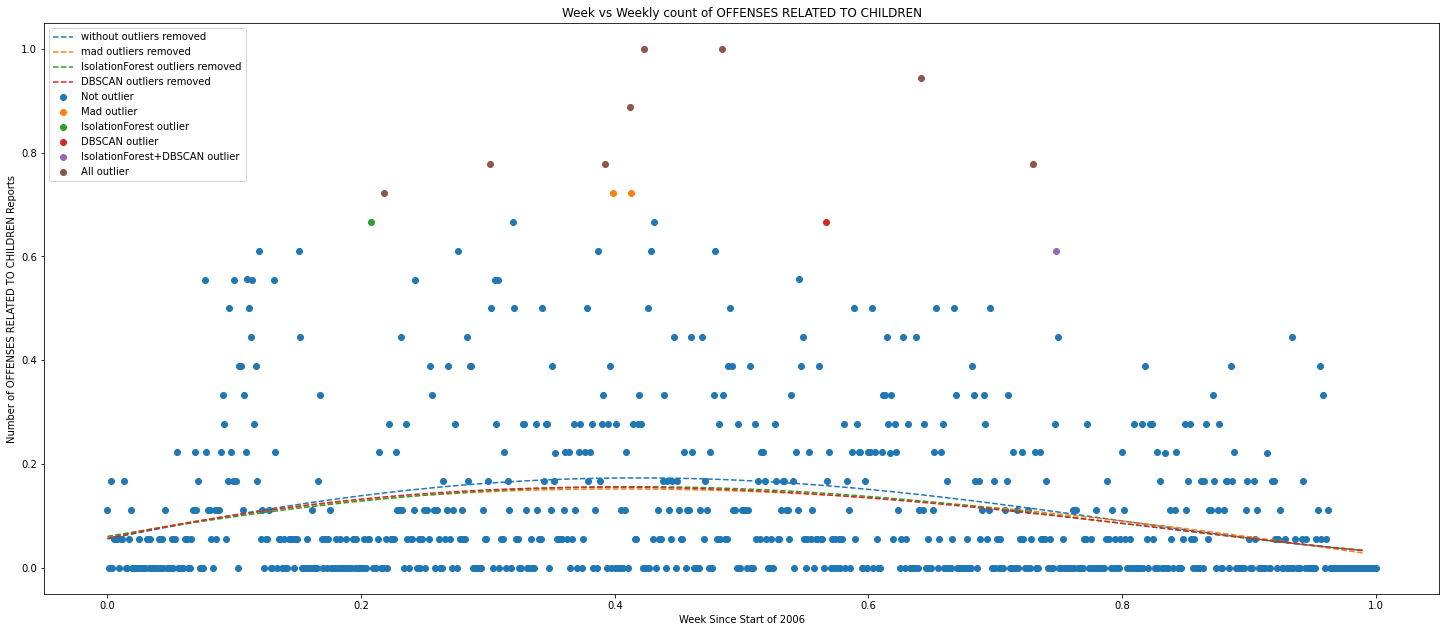

Detecting Outliers on: weeks vs OTHER OFFENSES RELATED TO THEF
target outlier count 10 vs 72 with MAD m: 1.66
target outlier count 10 vs 36 with MAD m: 1.8199999999999998
target outlier count 10 vs 22 with MAD m: 1.9799999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 10 vs 13 with MAD m: 2.1399999999999997
target outlier count 10 vs 8 with MAD m: 2.3
target outlier count 10 vs 13 with MAD m: 2.2199999999999998
target outlier count 10 vs 8 with MAD m: 2.26
target outlier count 10 vs 13 with MAD m: 2.2399999999999998
target outlier count 10 vs 8 with MAD m: 2.2499999999999996
target outlier count 10 vs 12 with MAD m: 2.2449999999999997
target outlier count 10 vs 8 with MAD m: 2.2474999999999996
target outlier count 10 vs 8 with MAD m: 2.2462499999999994
ta

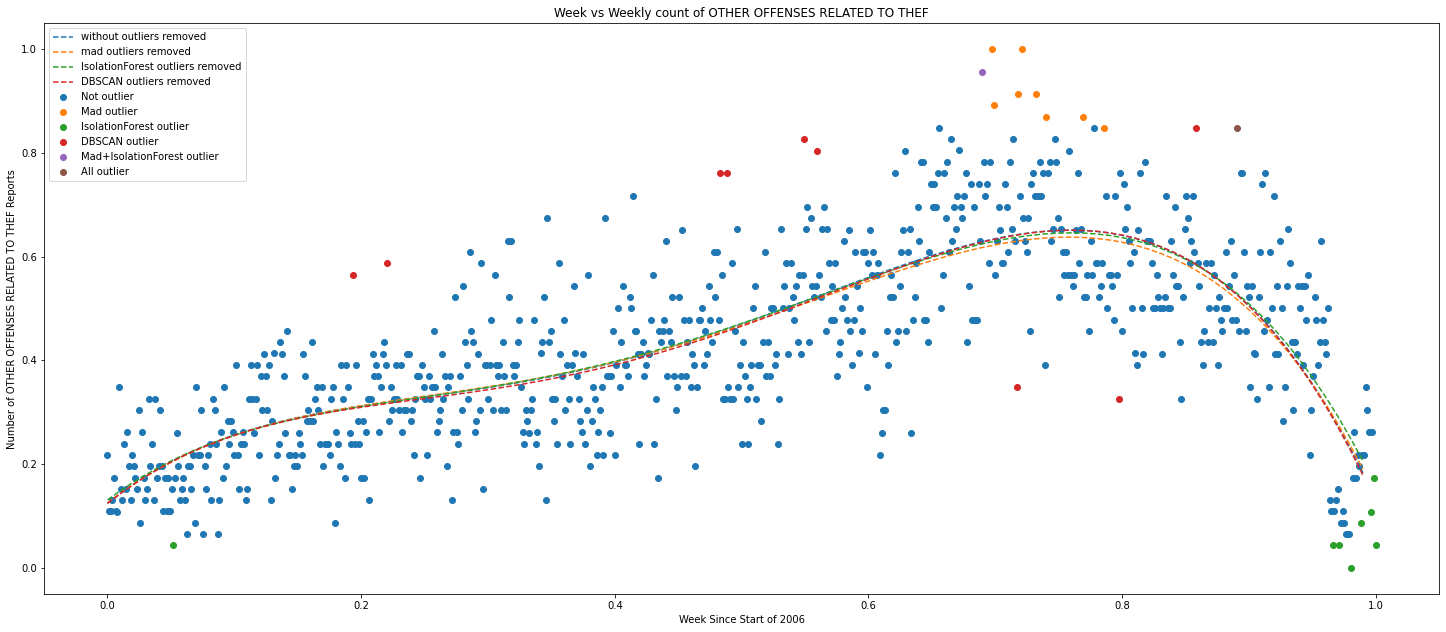

Detecting Outliers on: weeks vs OTHER STATE LAWS
Detecting Outliers on: weeks vs OTHER STATE LAWS (NON PENAL LA
target outlier count 10 vs 79 with MAD m: 1.66
target outlier count 10 vs 60 with MAD m: 1.8199999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 10 vs 60 with MAD m: 1.9799999999999998
target outlier count 10 vs 44 with MAD m: 2.1399999999999997
target outlier count 10 vs 29 with MAD m: 2.3
target outlier count 10 vs 29 with MAD m: 2.46
target outlier count 10 vs 23 with MAD m: 2.62
target outlier count 10 vs 16 with MAD m: 2.7800000000000002
target outlier count 10 vs 12 with MAD m: 2.9400000000000004
target outlier count 10 vs 12 with MAD m: 3.1000000000000005
target outlier count 10 vs 9 with MAD m: 3.2600000000000007
target outlier count 10 

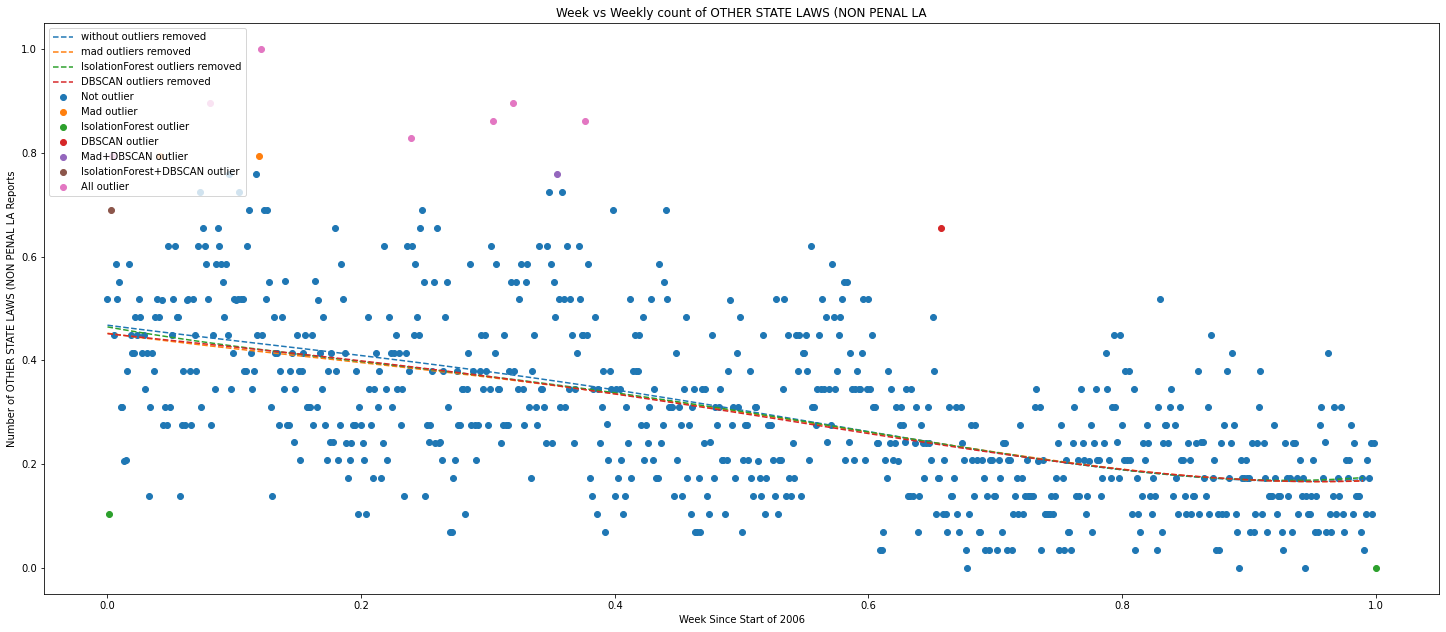

Detecting Outliers on: weeks vs OTHER STATE LAWS (NON PENAL LAW)
Detecting Outliers on: weeks vs OTHER TRAFFIC INFRACTION
Detecting Outliers on: weeks vs PETIT LARCENY
target outlier count 8 vs 78 with MAD m: 1.66
target outlier count 8 vs 58 with MAD m: 1.8199999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 8 vs 39 with MAD m: 1.9799999999999998
target outlier count 8 vs 32 with MAD m: 2.1399999999999997
target outlier count 8 vs 23 with MAD m: 2.3
target outlier count 8 vs 22 with MAD m: 2.46
target outlier count 8 vs 19 with MAD m: 2.62
target outlier count 8 vs 13 with MAD m: 2.7800000000000002
target outlier count 8 vs 11 with MAD m: 2.9400000000000004
target outlier count 8 vs 10 with MAD m: 3.1000000000000005
target outlier count 8 vs 8 with MAD m

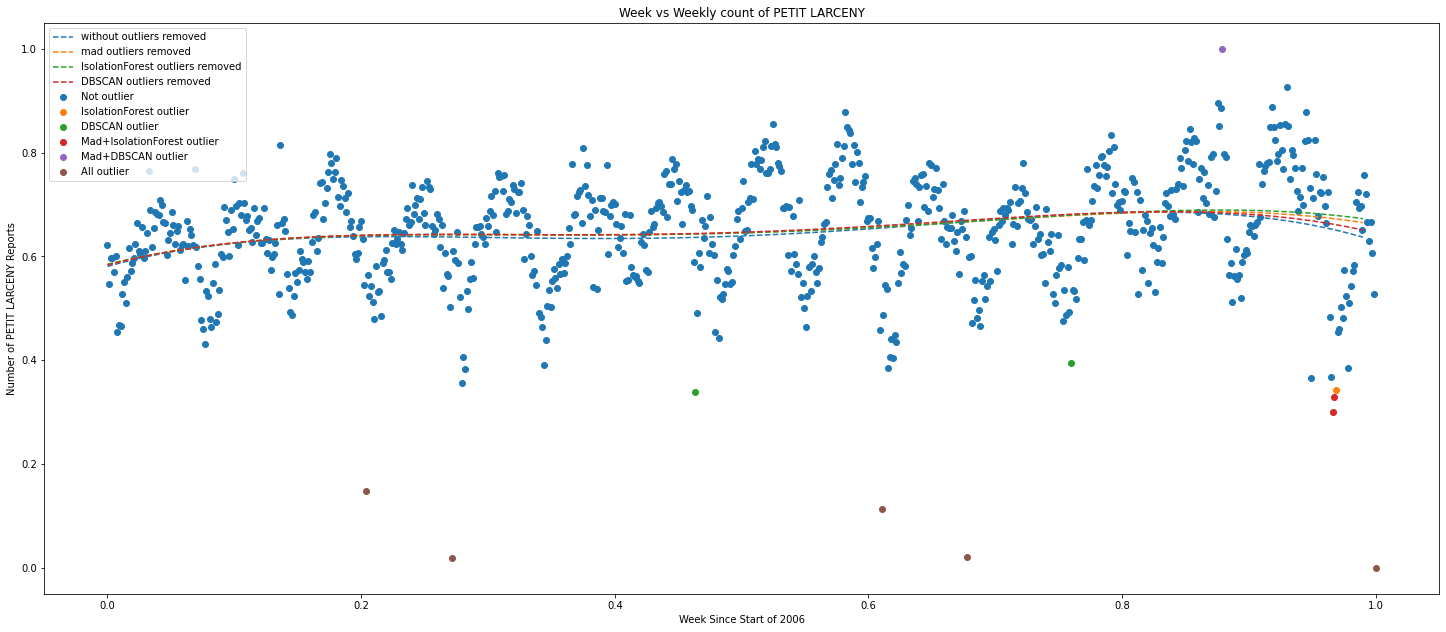

Detecting Outliers on: weeks vs PETIT LARCENY OF MOTOR VEHICLE
target outlier count 10 vs 106 with MAD m: 1.66
target outlier count 10 vs 106 with MAD m: 1.8199999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 10 vs 106 with MAD m: 1.9799999999999998
target outlier count 10 vs 44 with MAD m: 2.1399999999999997
target outlier count 10 vs 44 with MAD m: 2.3
target outlier count 10 vs 44 with MAD m: 2.46
target outlier count 10 vs 44 with MAD m: 2.62
target outlier count 10 vs 17 with MAD m: 2.7800000000000002
target outlier count 10 vs 17 with MAD m: 2.9400000000000004
target outlier count 10 vs 17 with MAD m: 3.1000000000000005
target outlier count 10 vs 17 with MAD m: 3.2600000000000007
target outlier count 10 vs 11 with MAD m: 3.420000000000001
target ou

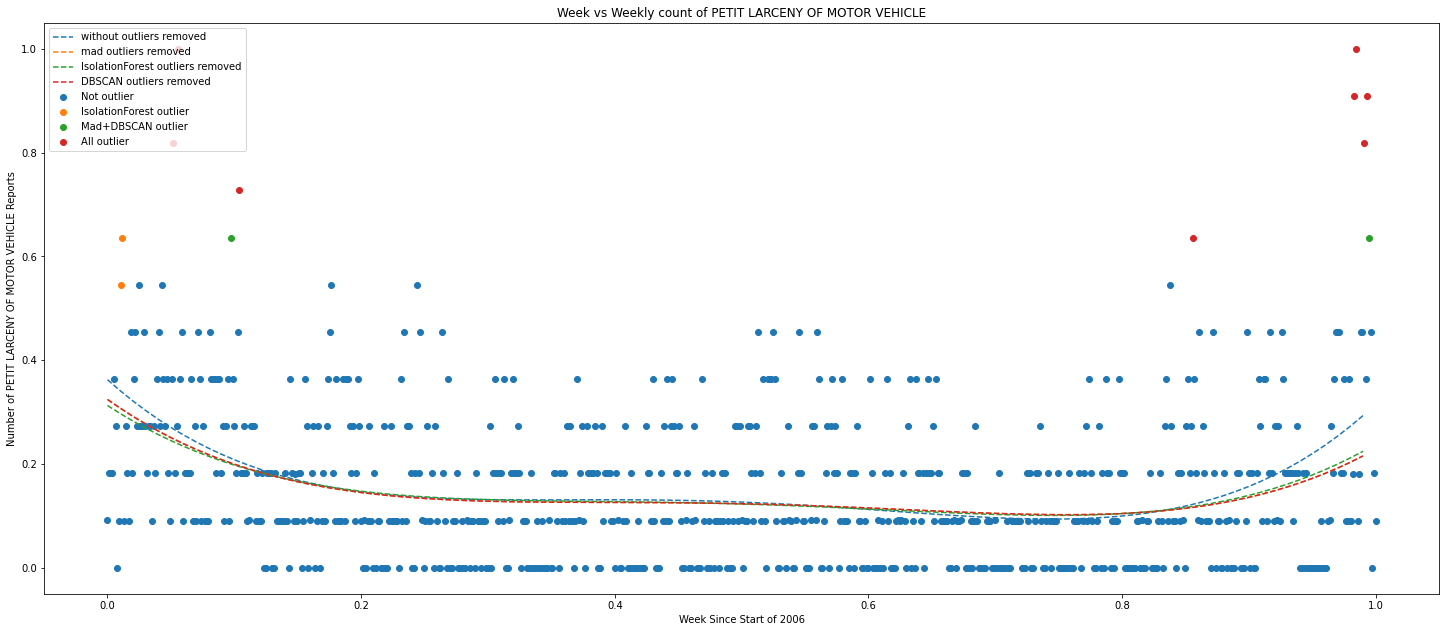

Detecting Outliers on: weeks vs POSSESSION OF STOLEN PROPERTY
target outlier count 10 vs 61 with MAD m: 1.66
target outlier count 10 vs 35 with MAD m: 1.8199999999999998
target outlier count 10 vs 24 with MAD m: 1.9799999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 10 vs 13 with MAD m: 2.1399999999999997
target outlier count 10 vs 9 with MAD m: 2.3
target outlier count 10 vs 10 with MAD m: 2.2199999999999998
target outlier count 10 vs 68 with DBSCAN eps 0.02
target outlier count 10 vs 9 with DBSCAN eps 0.04
target outlier count 10 vs 20 with DBSCAN eps 0.03
target outlier count 10 vs 14 with DBSCAN eps 0.034999999999999996
target outlier count 10 vs 9 with DBSCAN eps 0.039999999999999994
target outlier count 10 vs 10 with DBSCAN eps 0.03749999999999999


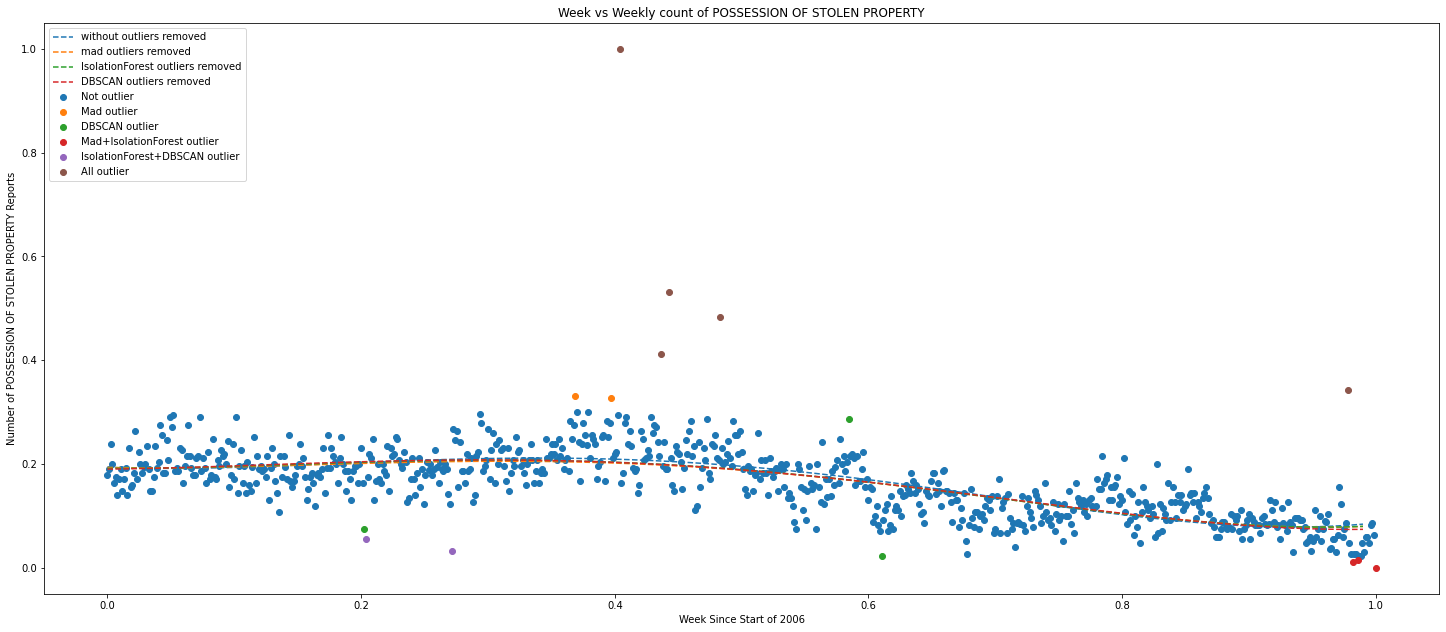

Detecting Outliers on: weeks vs PROSTITUTION & RELATED OFFENSES
target outlier count 10 vs 95 with MAD m: 1.66
target outlier count 10 vs 95 with MAD m: 1.8199999999999998
target outlier count 10 vs 95 with MAD m: 1.9799999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 10 vs 56 with MAD m: 2.1399999999999997
target outlier count 10 vs 56 with MAD m: 2.3
target outlier count 10 vs 56 with MAD m: 2.46
target outlier count 10 vs 56 with MAD m: 2.62
target outlier count 10 vs 39 with MAD m: 2.7800000000000002
target outlier count 10 vs 39 with MAD m: 2.9400000000000004
target outlier count 10 vs 39 with MAD m: 3.1000000000000005
target outlier count 10 vs 39 with MAD m: 3.2600000000000007
target outlier count 10 vs 31 with MAD m: 3.420000000000001
target outl

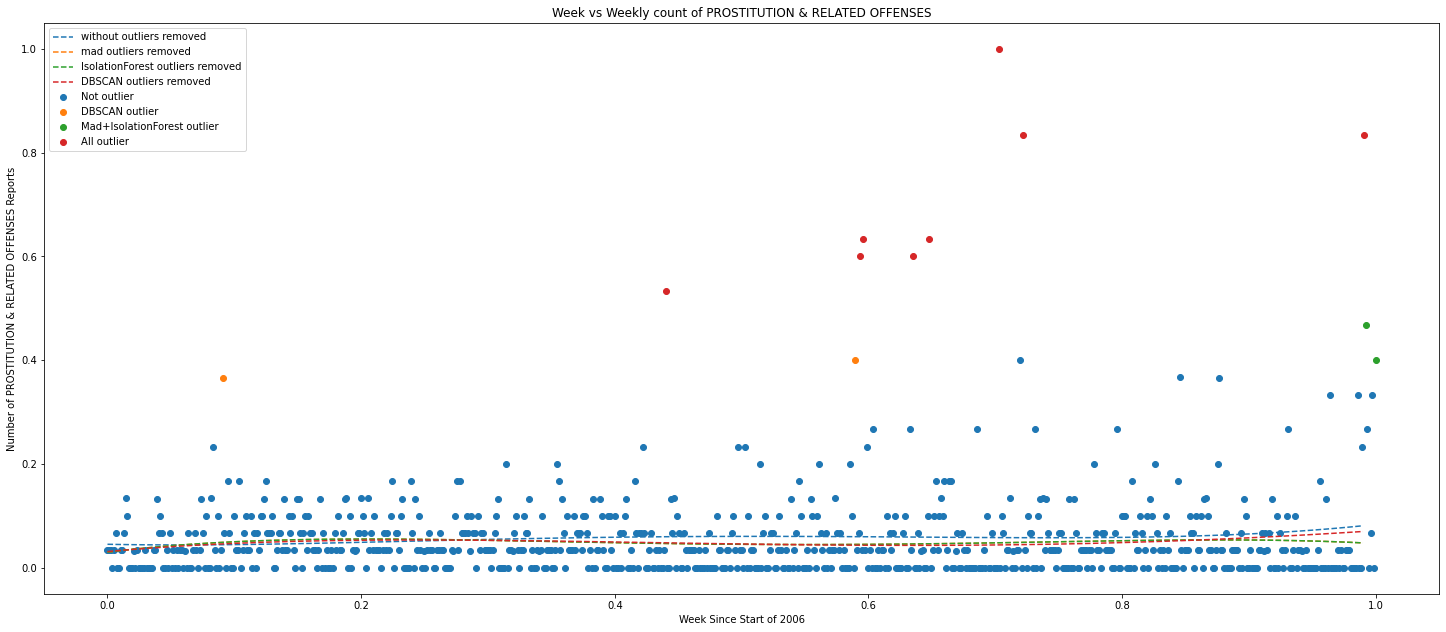

Detecting Outliers on: weeks vs RAPE
target outlier count 10 vs 112 with MAD m: 1.66
target outlier count 10 vs 90 with MAD m: 1.8199999999999998
target outlier count 10 vs 76 with MAD m: 1.9799999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 10 vs 63 with MAD m: 2.1399999999999997
target outlier count 10 vs 51 with MAD m: 2.3
target outlier count 10 vs 46 with MAD m: 2.46
target outlier count 10 vs 44 with MAD m: 2.62
target outlier count 10 vs 38 with MAD m: 2.7800000000000002
target outlier count 10 vs 32 with MAD m: 2.9400000000000004
target outlier count 10 vs 28 with MAD m: 3.1000000000000005
target outlier count 10 vs 24 with MAD m: 3.2600000000000007
target outlier count 10 vs 24 with MAD m: 3.420000000000001
target outlier count 10 vs 20 with MA

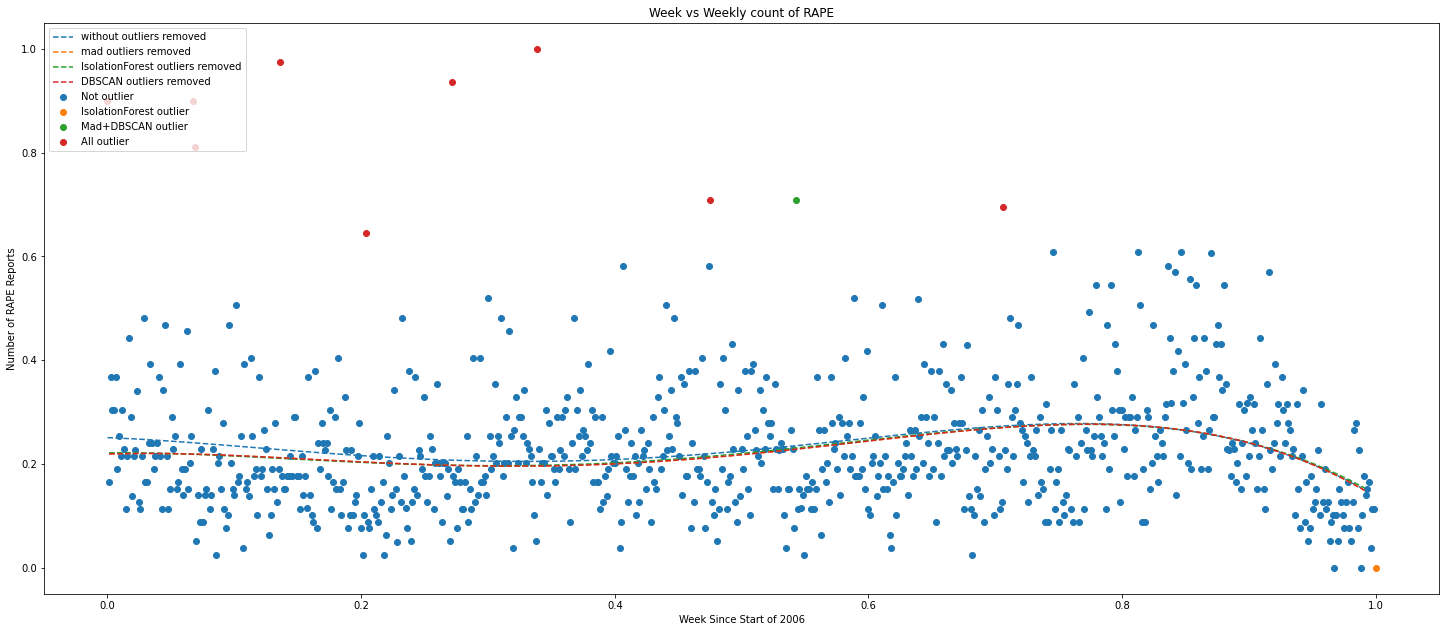

Detecting Outliers on: weeks vs ROBBERY
target outlier count 10 vs 51 with MAD m: 1.66
target outlier count 10 vs 35 with MAD m: 1.8199999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 10 vs 20 with MAD m: 1.9799999999999998
target outlier count 10 vs 15 with MAD m: 2.1399999999999997
target outlier count 10 vs 8 with MAD m: 2.3
target outlier count 10 vs 9 with MAD m: 2.2199999999999998
target outlier count 10 vs 15 with MAD m: 2.1399999999999997
target outlier count 10 vs 12 with MAD m: 2.1799999999999997
target outlier count 10 vs 9 with MAD m: 2.2199999999999998
target outlier count 10 vs 11 with MAD m: 2.1999999999999997
target outlier count 10 vs 10 with MAD m: 2.2099999999999995
target outlier count 10 vs 301 with DBSCAN eps 0.02
target outlier cou

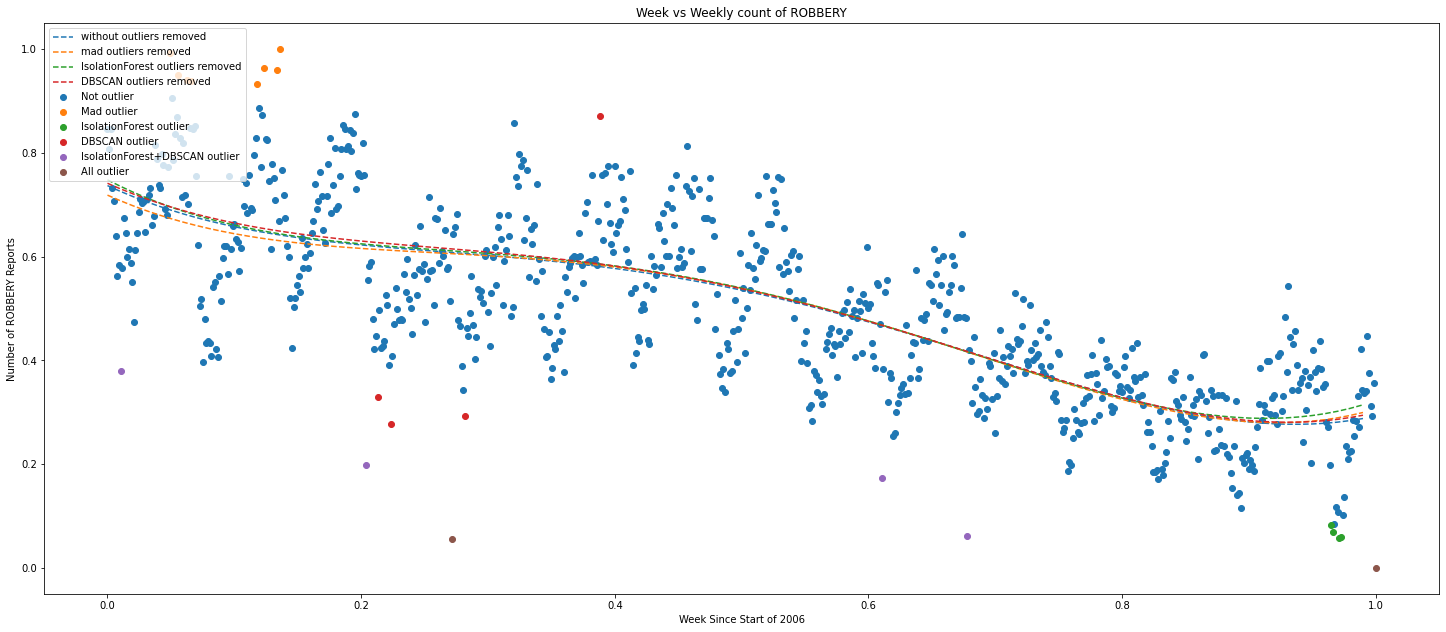

Detecting Outliers on: weeks vs SEX CRIMES
target outlier count 7 vs 86 with MAD m: 1.66
target outlier count 7 vs 70 with MAD m: 1.8199999999999998
target outlier count 7 vs 63 with MAD m: 1.9799999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 7 vs 58 with MAD m: 2.1399999999999997
target outlier count 7 vs 49 with MAD m: 2.3
target outlier count 7 vs 40 with MAD m: 2.46
target outlier count 7 vs 38 with MAD m: 2.62
target outlier count 7 vs 33 with MAD m: 2.7800000000000002
target outlier count 7 vs 31 with MAD m: 2.9400000000000004
target outlier count 7 vs 27 with MAD m: 3.1000000000000005
target outlier count 7 vs 25 with MAD m: 3.2600000000000007
target outlier count 7 vs 25 with MAD m: 3.420000000000001
target outlier count 7 vs 24 with MAD m: 3.5

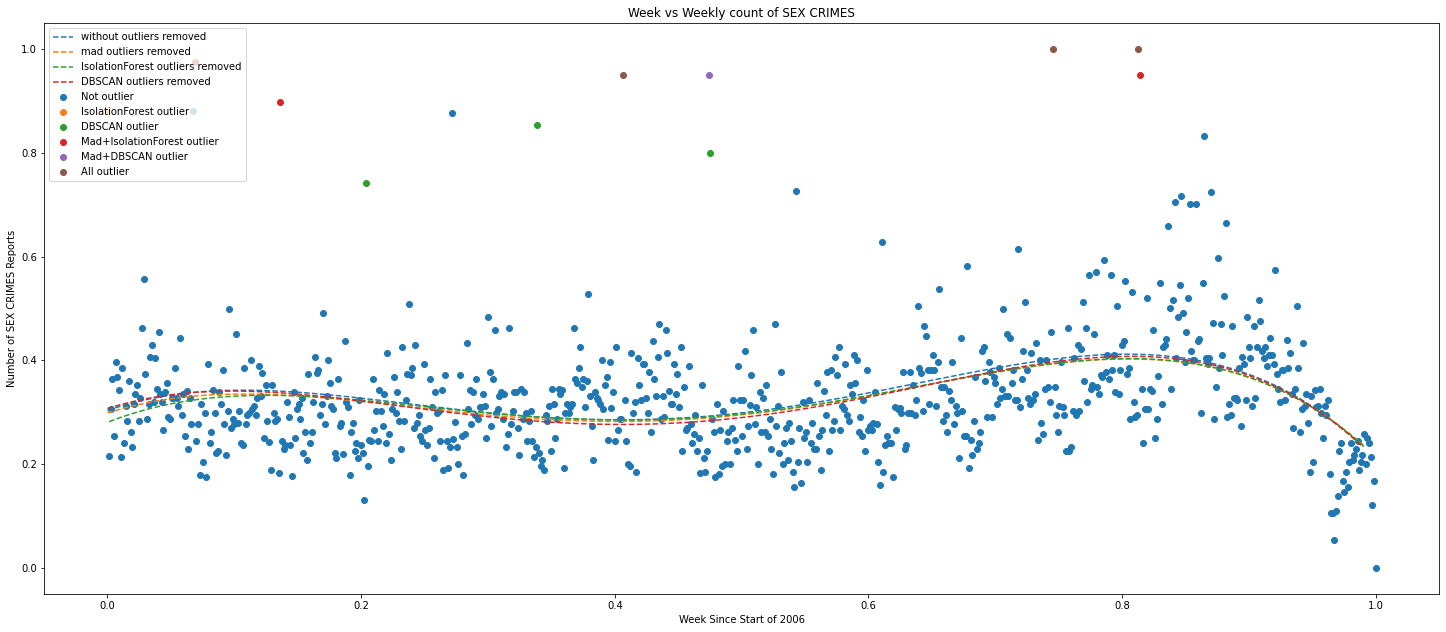

Detecting Outliers on: weeks vs THEFT OF SERVICES
target outlier count 10 vs 15 with MAD m: 1.66
target outlier count 10 vs 6 with MAD m: 1.8199999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 10 vs 15 with MAD m: 1.7399999999999998
target outlier count 10 vs 6 with MAD m: 1.7799999999999998
target outlier count 10 vs 6 with MAD m: 1.7599999999999998
target outlier count 10 vs 15 with MAD m: 1.7399999999999998
target outlier count 10 vs 15 with MAD m: 1.7499999999999998
target outlier count 10 vs 6 with MAD m: 1.7599999999999998
target outlier count 10 vs 15 with MAD m: 1.755
target outlier count 10 vs 6 with MAD m: 1.7574999999999998
target outlier count 10 vs 14 with MAD m: 1.7562499999999999
target outlier count 10 vs 6 with MAD m: 1.756875
target out

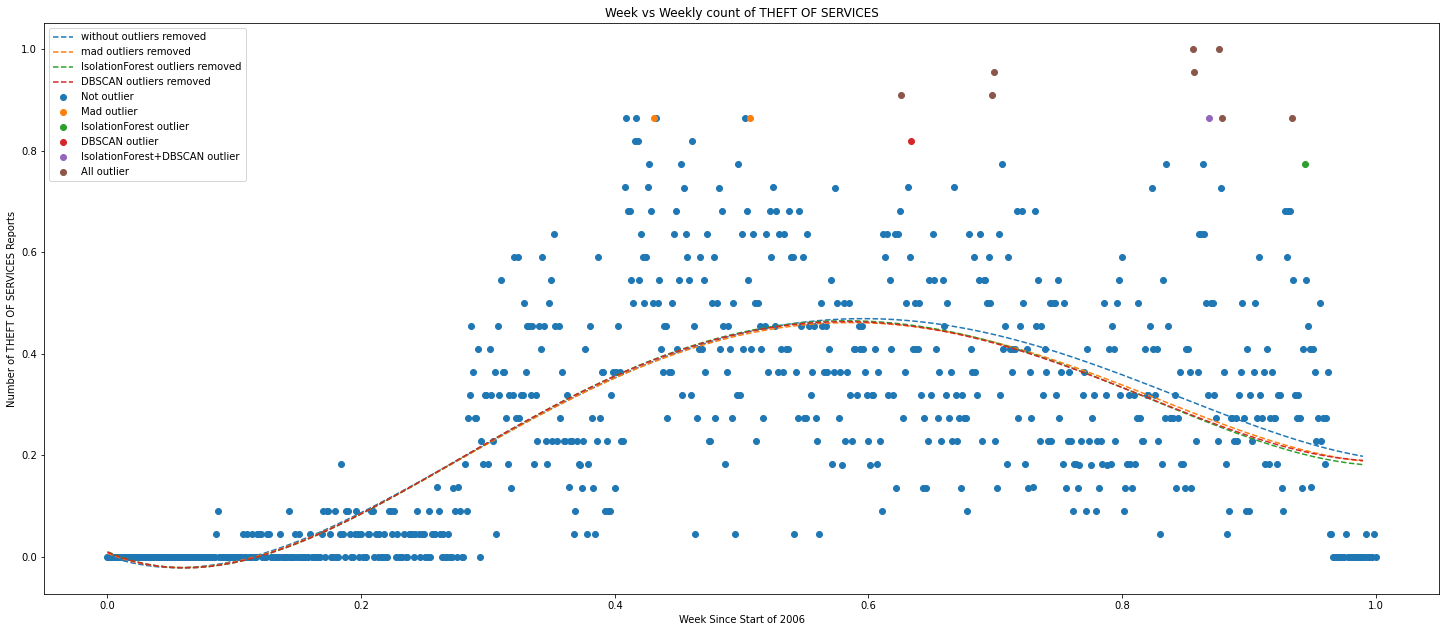

Detecting Outliers on: weeks vs THEFT-FRAUD
target outlier count 10 vs 129 with MAD m: 1.66
target outlier count 10 vs 107 with MAD m: 1.8199999999999998
target outlier count 10 vs 90 with MAD m: 1.9799999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 10 vs 81 with MAD m: 2.1399999999999997
target outlier count 10 vs 65 with MAD m: 2.3
target outlier count 10 vs 58 with MAD m: 2.46
target outlier count 10 vs 47 with MAD m: 2.62
target outlier count 10 vs 39 with MAD m: 2.7800000000000002
target outlier count 10 vs 32 with MAD m: 2.9400000000000004
target outlier count 10 vs 26 with MAD m: 3.1000000000000005
target outlier count 10 vs 21 with MAD m: 3.2600000000000007
target outlier count 10 vs 17 with MAD m: 3.420000000000001
target outlier count 10 vs 14

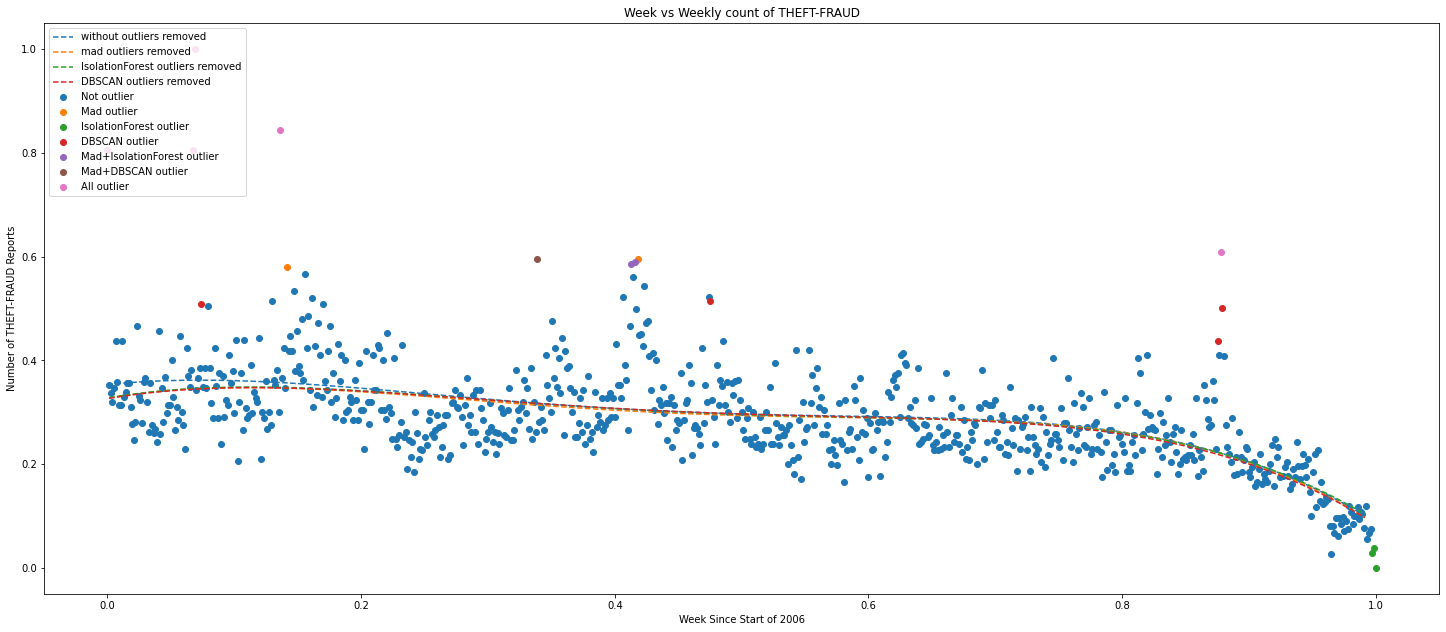

Detecting Outliers on: weeks vs UNAUTHORIZED USE OF A VEHICLE
target outlier count 10 vs 75 with MAD m: 1.66
target outlier count 10 vs 51 with MAD m: 1.8199999999999998
target outlier count 10 vs 41 with MAD m: 1.9799999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 10 vs 28 with MAD m: 2.1399999999999997
target outlier count 10 vs 18 with MAD m: 2.3
target outlier count 10 vs 14 with MAD m: 2.46
target outlier count 10 vs 10 with MAD m: 2.62
target outlier count 10 vs 322 with DBSCAN eps 0.02
target outlier count 10 vs 36 with DBSCAN eps 0.04
target outlier count 10 vs 11 with DBSCAN eps 0.06
target outlier count 10 vs 4 with DBSCAN eps 0.08
target outlier count 10 vs 4 with DBSCAN eps 0.07
target outlier count 10 vs 11 with DBSCAN eps 0.060000000000000

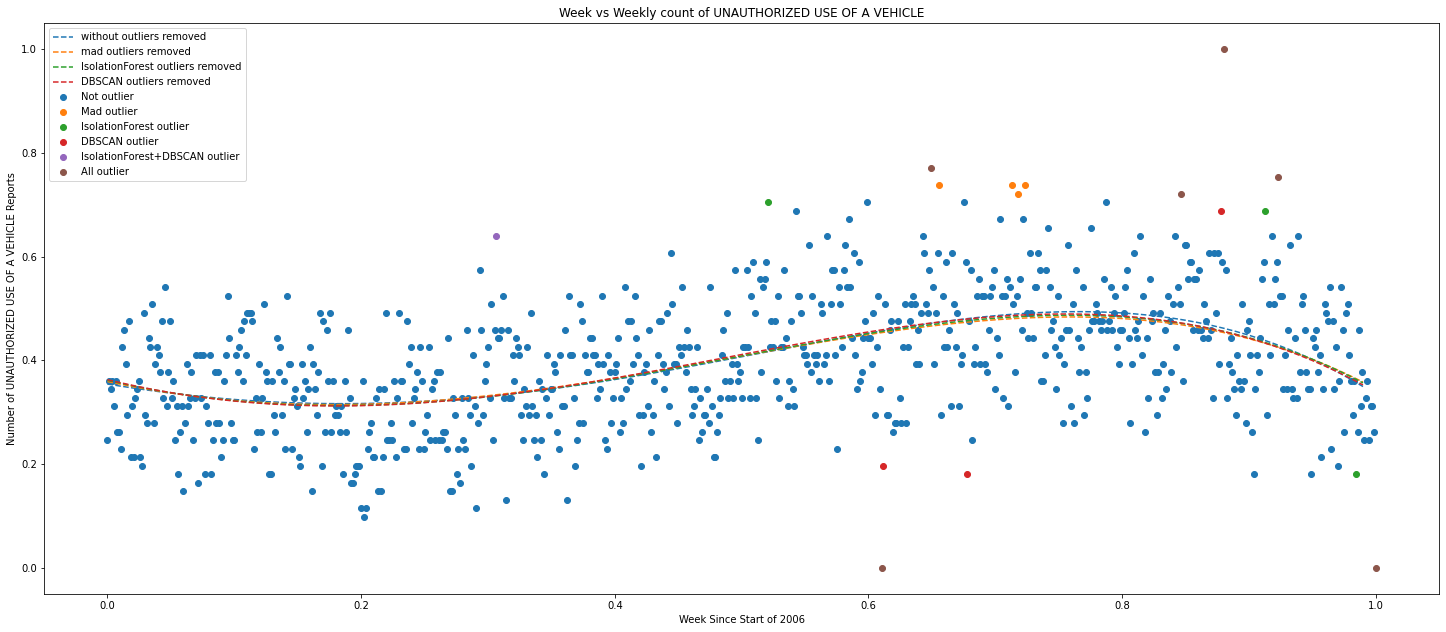

Detecting Outliers on: weeks vs UNDER THE INFLUENCE OF DRUGS
Detecting Outliers on: weeks vs UNLAWFUL POSS. WEAP. ON SCHOOL
Detecting Outliers on: weeks vs VEHICLE AND TRAFFIC LAWS
target outlier count 10 vs 97 with MAD m: 1.66
target outlier count 10 vs 72 with MAD m: 1.8199999999999998
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
target outlier count 10 vs 61 with MAD m: 1.9799999999999998
target outlier count 10 vs 47 with MAD m: 2.1399999999999997
target outlier count 10 vs 36 with MAD m: 2.3
target outlier count 10 vs 33 with MAD m: 2.46
target outlier count 10 vs 27 with MAD m: 2.62
target outlier count 10 vs 21 with MAD m: 2.7800000000000002
target outlier count 10 vs 16 with MAD m: 2.9400000000000004
target outlier count 10 vs 14 with MAD m: 3.1000000000000005
target outlier 

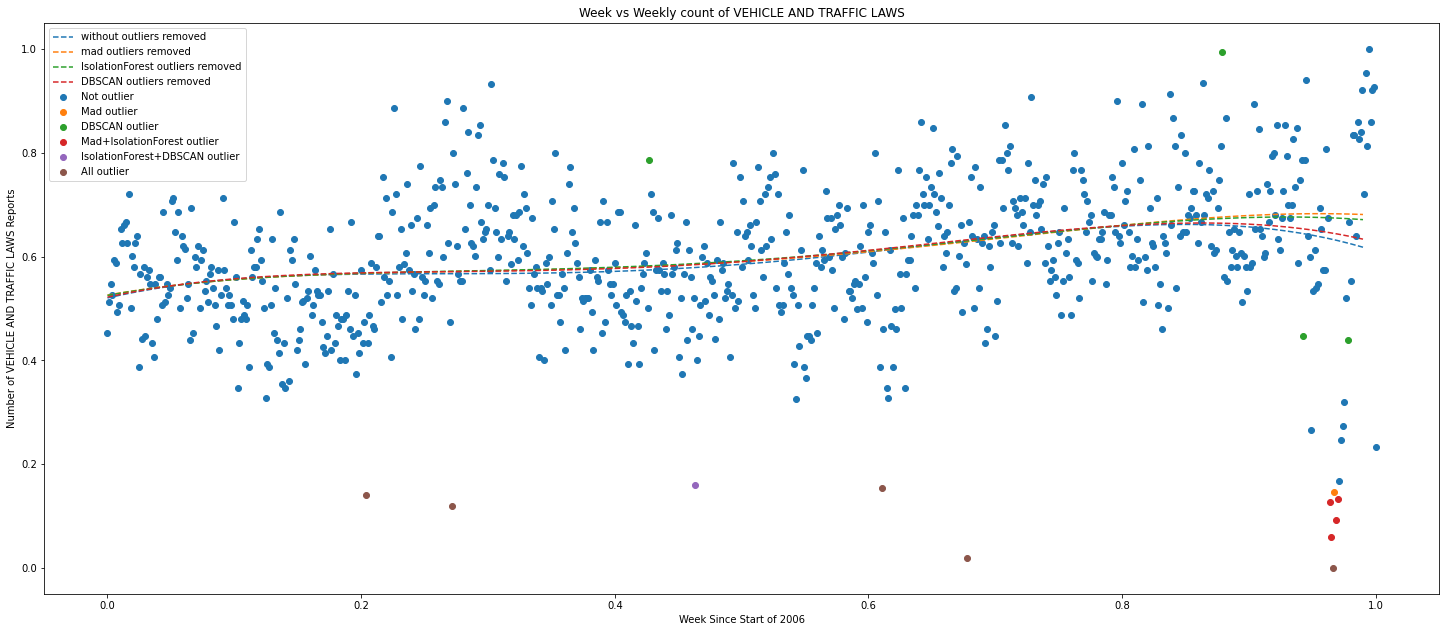

r2_standard    r2_mad  r2_dbscan  r2_isofor  \
All Types                           0.359471  0.377165   0.398021   0.407491   
ADMINISTRATIVE CODE                 0.052153  0.049694   0.051280   0.053831   
ALCOHOLIC BEVERAGE CONTROL LAW      0.030163  0.029083   0.032761   0.032136   
ARSON                               0.519150  0.526098   0.539637   0.555333   
ASSAULT 3 & RELATED OFFENSES        0.091328  0.064311   0.064311   0.100025   
BURGLAR'S TOOLS                     0.121371  0.124452   0.128054   0.128483   
BURGLARY                            0.652825  0.742527   0.750974   0.751983   
CRIMINAL MISCHIEF & RELATED OF      0.247659  0.254298   0.280235   0.273961   
CRIMINAL TRESPASS                   0.645361  0.656768   0.647253   0.658428   
DANGEROUS DRUGS                     0.806338  0.807032   0.826702   0.846511   
DANGEROUS WEAPONS                   0.721472  0.707430   0.730424   0.773206   
DISORDERLY CONDUCT                  0.238012  0.285597   0.302928   0.302066   
FELONY ASSAULT                      0.258252  0.262498   0.269849   0.281369   
FORGERY                             0.610118  0.558356   0.605720   0.648414   
FRAUDS                              0.445355  0.468869   0.486405   0.503800   
FRAUDULENT ACCOSTING                0.165492  0.184151   0.187695   0.185965   
GAMBLING                            0.039047  0.031377   0.040121   0.038506   
GRAND LARCENY                       0.207618  0.184110   0.215385   0.218118   
GRAND LARCENY OF MOTOR VEHICLE      0.779842  0.769912   0.795737   0.799388   
HARRASSMENT 2                       0.385916  0.423661   0.453779   0.434594   
INTOXICATED & IMPAIRED DRIVING      0.561085  0.536874   0.568582   0.602861   
KIDNAPPING & RELATED OFFENSES       0.334506  0.335859   0.350202   0.356445   
MISCELLANEOUS PENAL LAW             0.405852  0.438435   0.443049   0.461500   
MURDER & NON-NEGL. MANSLAUGHTER     0.186501  0.187606   0.198163   0.207337   
NYS LAWS-UNCLASSIFIED FELONY        0.397318  0.403887   0.406505   0.434738   
OFF. AGNST PUB ORD SENSBLTY &       0.742989  0.748411   0.754250   0.764261   
OFFENSES AGAINST PUBLIC ADMINI      0.633262  0.631869   0.641669   0.672960   
OFFENSES AGAINST PUBLIC SAFETY      0.013060  0.022882   0.025997   0.022882   
OFFENSES AGAINST THE PERSON         0.045721  0.057404   0.058571   0.057404   
OFFENSES INVOLVING FRAUD            0.452376  0.462226   0.461602   0.475313   
OFFENSES RELATED TO CHILDREN        0.065915  0.057770   0.062337   0.061721   
OTHER OFFENSES RELATED TO THEF      0.618086  0.616096   0.612634   0.637167   
OTHER STATE LAWS (NON PENAL LA      0.337234  0.338487   0.341673   0.343883   
PETIT LARCENY                       0.043003  0.054390   0.059377   0.052420   
PETIT LARCENY OF MOTOR VEHICLE      0.150076  0.119798   0.111304   0.119798   
POSSESSION OF STOLEN PROPERTY       0.444776  0.565077   0.576446   0.593122   
PROSTITUTION & RELATED OFFENSES     0.007141  0.005371   0.005371   0.011717   
RAPE                                0.046405  0.073275   0.068947   0.073275   
ROBBERY                             0.583435  0.593361   0.602202   0.617833   
SEX CRIMES                          0.122915  0.143097   0.141233   0.157825   
THEFT OF SERVICES                   0.477998  0.506467   0.514761   0.509221   
THEFT-FRAUD                         0.365221  0.436200   0.406875   0.437741   
UNAUTHORIZED USE OF A VEHICLE       0.263298  0.265046   0.278169   0.284731   
VEHICLE AND TRAFFIC LAWS            0.085742  0.132870   0.125165   0.099113   

                                 r2_mad_diff  r2_dbscan_diff  r2_isofor_diff  \
All Types                           0.017694        0.038549        0.048019   
ADMINISTRATIVE CODE                -0.002459       -0.000873        0.001678   
ALCOHOLIC BEVERAGE CONTROL LAW     -0.001080        0.002598        0.001974   
ARSON                               0.006948        0.020487        0.036183   
ASSAULT 3 & RELATED OFFENSES    

In [12]:
from timeit import default_timer as timer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit
from numpy import arange

results = pd.DataFrame({'r2_standard':[], 'r2_mad': [], 'r2_dbscan': [], 'r2_isofor': [], 
                        'r2_mad_diff': [], 'r2_dbscan_diff': [], 'r2_isofor_diff': [], 
                        'time_mad': [], 'time_dbscan': [], 'time_isofor': []})

for offense_desc, type_to_weekly_count in type_to_weekly_counts.items():
    print(f"Detecting Outliers on: weeks vs {offense_desc}")
    max_count = type_to_weekly_count["count"].max()
    all_x_length = len(type_to_weekly_count)

    minmax_transformer = Pipeline(steps=[
        ('minmax', MinMaxScaler())])
    ct = ColumnTransformer(
        remainder='passthrough', #passthough features not listed
        transformers=[('mm', minmax_transformer , ["week", "count"])])
    type_to_weekly_count = ct.fit_transform(type_to_weekly_count)
    type_to_weekly_count = pd.DataFrame(type_to_weekly_count, columns = ["week", "count", "outlier_type", "week_dt"])
    type_to_weekly_count['outlier_type'] = 0

    outlier_count_target = get_true_outlier_count(offense_desc)

    if type_to_weekly_count["count"].median(skipna = True) == 0:
        continue # MAD won't work

    # add row to results for offense_desc
    results = results.append(pd.Series(name=offense_desc))

    # add a little bit of noise to prevent finding appropriate mad m value from getting stuck
    noise = np.random.normal(0, .0001, type_to_weekly_count["count"].shape)
    type_to_weekly_count["count"] = type_to_weekly_count["count"] + noise
    
    # loop to make numbers of outliers found by MAD equal to outlier_count_target
    mad_outlier_count = 10000
    m = 1.5
    start_mad_z_scores = timer()
    mad_z_scores = get_mad_z_scores(type_to_weekly_count["count"].to_numpy())
    end_mad_z_scores = timer()
    increment_by = .16
    forward = True
    while mad_outlier_count != outlier_count_target:
        # reset mad outliers
        type_to_weekly_count.loc[(type_to_weekly_count.outlier_type == 1),'outlier_type']= 0
        # increment m and look again
        if mad_outlier_count > outlier_count_target:
            if not forward:
                forward = True
                increment_by = increment_by / 2
            m = m + increment_by
        else:
            # we increased too much go back
            if forward:
                forward = False
                increment_by = increment_by / 2
            m = m - increment_by
        start = timer()
        mad_outliers = get_mad_outliers(mad_z_scores, m)
        end = timer()
        for i, row in type_to_weekly_count.iterrows():
            if mad_outliers[i] == -1:
                type_to_weekly_count.at[i,'outlier_type'] =  1
        mad_outlier_count = len(type_to_weekly_count.loc[type_to_weekly_count['outlier_type'].isin([1])])
        print (f"target outlier count {outlier_count_target} vs {mad_outlier_count} with MAD m: {m}")
    results.loc[offense_desc,'time_mad']= end_mad_z_scores - start_mad_z_scores + end - start   


    # Find the number of outliers specifed with outlier_count_target using isoloation forests            
    outliers_fraction = outlier_count_target/all_x_length
    ifclf = IsolationForest(random_state=0, contamination=outliers_fraction, n_estimators=50)
    start = timer()
    if_outliers = ifclf.fit_predict(type_to_weekly_count[["week", "count"]])
    end = timer()
    results.loc[offense_desc,'time_isofor']= end - start   
    for i, row in type_to_weekly_count.iterrows():
        if if_outliers[i] == -1:
            if row['outlier_type'] == 0:
                type_to_weekly_count.at[i,'outlier_type'] = 2
            elif row['outlier_type'] == 1:
                type_to_weekly_count.at[i,'outlier_type'] = 4


    dbscan_outlier_count = 1000000
    eps = 0.0
    increment_by = .02
    forward = True
    # loop to make numbers of outliers found by DBSCAN equal to outlier_count_target
    while dbscan_outlier_count != outlier_count_target:
        # reset dbscan outliers
        type_to_weekly_count.loc[(type_to_weekly_count.outlier_type == 3),'outlier_type']= 0
        type_to_weekly_count.loc[(type_to_weekly_count.outlier_type == 5),'outlier_type']= 1
        type_to_weekly_count.loc[(type_to_weekly_count.outlier_type == 6),'outlier_type']= 2
        type_to_weekly_count.loc[(type_to_weekly_count.outlier_type == 7),'outlier_type']= 4
        # increment eps and look again
        if dbscan_outlier_count > outlier_count_target:
            if not forward:
                forward = True
                increment_by = increment_by / 2
            eps = eps + increment_by
        else:
            # we increase too much go back
            if forward:
                forward = False
                increment_by = increment_by / 2
            eps = eps - increment_by
        dbclf = DBSCAN(eps = eps, metric="euclidean")
        start = timer()
        db_outliers = dbclf.fit_predict(type_to_weekly_count[["week", "count"]])
        end = timer()

        for i, row in type_to_weekly_count.iterrows():
            if db_outliers[i] == -1:
                if row['outlier_type'] == 0:
                    type_to_weekly_count.at[i,'outlier_type'] = 3
                elif row['outlier_type'] == 1:
                    type_to_weekly_count.at[i,'outlier_type'] = 5
                elif row['outlier_type'] == 2:
                    type_to_weekly_count.at[i,'outlier_type'] = 6
                elif row['outlier_type'] == 4:
                    type_to_weekly_count.at[i,'outlier_type'] = 7
        dbscan_outlier_count = len(type_to_weekly_count.loc[type_to_weekly_count['outlier_type'].isin([3,5,6,7])])
        print (f"target outlier count {outlier_count_target} vs {dbscan_outlier_count} with DBSCAN eps {eps}")
    results.loc[offense_desc,'time_dbscan']= end - start   

    x = type_to_weekly_count.loc[type_to_weekly_count['outlier_type'] == 0]['week']
    y = type_to_weekly_count.loc[type_to_weekly_count['outlier_type'] == 0]['count']
    x_o_m = type_to_weekly_count.loc[type_to_weekly_count['outlier_type'] == 1]['week']
    y_o_m = type_to_weekly_count.loc[type_to_weekly_count['outlier_type'] == 1]['count']
    x_o_if = type_to_weekly_count.loc[type_to_weekly_count['outlier_type'] == 2]['week']
    y_o_if = type_to_weekly_count.loc[type_to_weekly_count['outlier_type'] == 2]['count']
    x_o_db = type_to_weekly_count.loc[type_to_weekly_count['outlier_type'] == 3]['week']
    y_o_db = type_to_weekly_count.loc[type_to_weekly_count['outlier_type'] == 3]['count']
    x_o_m_if = type_to_weekly_count.loc[type_to_weekly_count['outlier_type'] == 4]['week']
    y_o_m_if = type_to_weekly_count.loc[type_to_weekly_count['outlier_type'] == 4]['count']
    x_o_m_db = type_to_weekly_count.loc[type_to_weekly_count['outlier_type'] == 5]['week']
    y_o_m_db = type_to_weekly_count.loc[type_to_weekly_count['outlier_type'] == 5]['count']
    x_o_if_db = type_to_weekly_count.loc[type_to_weekly_count['outlier_type'] == 6]['week']
    y_o_if_db = type_to_weekly_count.loc[type_to_weekly_count['outlier_type'] == 6]['count']
    x_o_all = type_to_weekly_count.loc[type_to_weekly_count['outlier_type'] == 7]['week']
    y_o_all = type_to_weekly_count.loc[type_to_weekly_count['outlier_type'] == 7]['count']

    xys = [ (x,y, "Not outlier"), 
            (x_o_m,y_o_m, "Mad outlier"), 
            (x_o_if,y_o_if,"IsolationForest outlier"), 
            (x_o_db,y_o_db,"DBSCAN outlier"), 
            (x_o_m_if,y_o_m_if,"Mad+IsolationForest outlier"), 
            (x_o_m_db,y_o_m_db,"Mad+DBSCAN outlier"), 
            (x_o_if_db,y_o_if_db,"IsolationForest+DBSCAN outlier"),
            (x_o_all,y_o_all, "All outlier") ]
    fig = plt.gcf()
    fig.set_size_inches(25,10.5)

    #Graph points
    for x,y,desc in xys:
        if len(x) > 0:
            # plot input vs output
            plt.scatter(x, y, label=desc)
    
    results_r2_col_and_line_descs = np.array([
        ('r2_standard', "without outliers removed"), 
        ('r2_mad', "mad outliers removed"), 
        ('r2_dbscan', "IsolationForest outliers removed"), 
        ('r2_isofor', "DBSCAN outliers removed")])

    #Graph curves
    for i, results_r2_col_and_line_desc in enumerate(results_r2_col_and_line_descs):
        r2_col, desc = results_r2_col_and_line_desc
        if i == 0:
            # line without outliers removed
            x = type_to_weekly_count['week']
            y = type_to_weekly_count['count']
            outlier_dates = None
        elif i == 1:
            # line with mad outliers removed
            x = type_to_weekly_count.loc[~type_to_weekly_count['outlier_type'].isin([1,4,5,7])]['week']
            y = type_to_weekly_count.loc[~type_to_weekly_count['outlier_type'].isin([1,4,5,7])]['count']
            outlier_dates = type_to_weekly_count.loc[type_to_weekly_count['outlier_type'].isin([1,4,5,7])]['week_dt']
        elif i == 2:
            # line with IsolationForest outliers removed
            x = type_to_weekly_count.loc[~type_to_weekly_count['outlier_type'].isin([2,4,6,7])]['week']
            y = type_to_weekly_count.loc[~type_to_weekly_count['outlier_type'].isin([2,4,6,7])]['count']
            outlier_dates = type_to_weekly_count.loc[type_to_weekly_count['outlier_type'].isin([2,4,6,7])]['week_dt']
        elif i == 3:
            # line with DBSCAN outliers removed
            x = type_to_weekly_count.loc[~type_to_weekly_count['outlier_type'].isin([3,5,6,7])]['week']
            y = type_to_weekly_count.loc[~type_to_weekly_count['outlier_type'].isin([3,5,6,7])]['count']
            outlier_dates = type_to_weekly_count.loc[type_to_weekly_count['outlier_type'].isin([3,5,6,7])]['week_dt']
        print(f"{desc} outlier count: {all_x_length - len(x)}")
        print(f"outlier week dates: \n{outlier_dates}")

        if i > 0 and len(x) == all_x_length:
            continue

        
        # curve fit
        popt, _ = curve_fit(objective_4th, x, y)
        # summarize the parameter values
        a, b, c, d, e = popt
        # define a sequence of inputs between the smallest and largest known inputs
        x_line = arange(min(x), max(x), .01)
        # calculate the output for the range
        y_line = objective_4th(x_line, a, b, c, d, e)
        # create a line plot for the mapping function
        plt.plot(x_line, y_line, '--',label=desc)

        r2 = get_r2(x,y,popt,objective_4th)
        # save r2 to results df
        results.loc[offense_desc,r2_col]= r2
        if r2_col != 'r2_standard':
            r2_std = results.loc[offense_desc,'r2_standard']
            results.loc[offense_desc,f"{r2_col}_diff"]= r2 - r2_std
        print(f"{desc} r2: {r2}")

    plt.title(f"Week vs Weekly count of {offense_desc}")
    plt.xlabel('Week Since Start of 2006')
    plt.ylabel(f"Number of {offense_desc} Reports")
    plt.legend(loc='upper left')
    plt.show()
results

In [13]:
results.to_latex('./results.tex')

r2_mad_diff mean 0.010892996159343898
r2_dbscan_diff mean 0.019579443374614838
r2_isofor_diff mean 0.02927308793186388
time_mad mean 0.0009271881585432725
time_dbscan mean 0.008612568701871416
time_isofor mean 0.15171755771999332


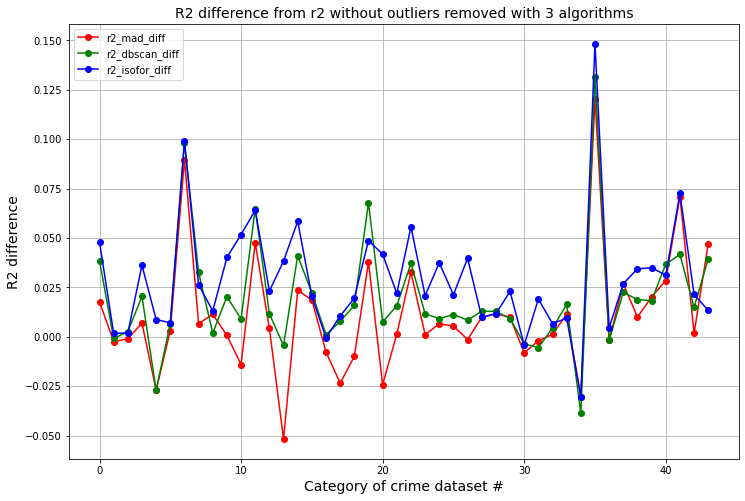

In [16]:
print(f"r2_mad_diff mean {results['r2_mad_diff'].mean()}")
print(f"r2_dbscan_diff mean {results['r2_dbscan_diff'].mean()}")
print(f"r2_isofor_diff mean {results['r2_isofor_diff'].mean()}")

print(f"time_mad mean {results['time_mad'].mean()}")
print(f"time_dbscan mean {results['time_dbscan'].mean()}")
print(f"time_isofor mean {results['time_isofor'].mean()}")


fig = plt.gcf()
fig.set_size_inches(12,8)

plt.plot(range(len(results)), results['r2_mad_diff'], color='red', marker='o', label= "r2_mad_diff")
plt.plot(range(len(results)), results['r2_dbscan_diff'], color='green', marker='o', label= "r2_dbscan_diff")
plt.plot(range(len(results)), results['r2_isofor_diff'], color='blue', marker='o', label= "r2_isofor_diff")
plt.title('R2 difference from r2 without outliers removed with 3 algorithms', fontsize=14)
plt.xlabel('Category of crime dataset #', fontsize=14)
plt.ylabel('R2 difference', fontsize=14)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

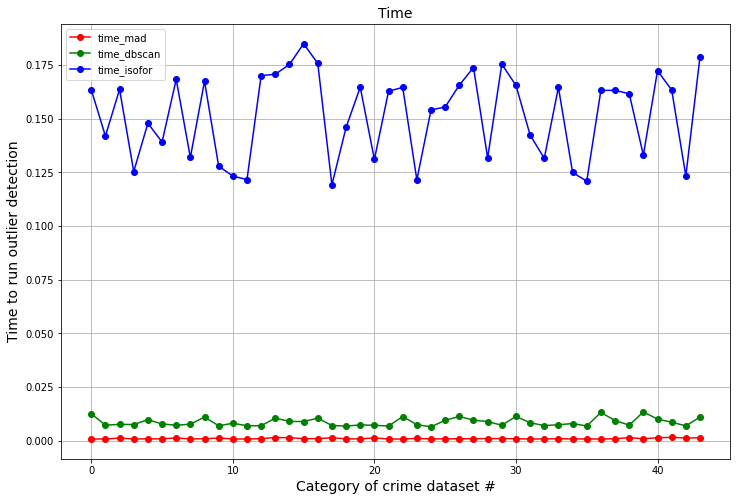

In [17]:
plt.plot(range(len(results)), results['time_mad'], color='red', marker='o', label= "time_mad")
plt.plot(range(len(results)), results['time_dbscan'], color='green', marker='o', label= "time_dbscan")
plt.plot(range(len(results)), results['time_isofor'], color='blue', marker='o', label= "time_isofor")

fig = plt.gcf()
fig.set_size_inches(12,8)

plt.title('Time', fontsize=14)
plt.xlabel('Category of crime dataset #', fontsize=14)
plt.ylabel('Time to run outlier detection', fontsize=14)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()